# **Test Set Scores**

In [1]:
import os
import sys
import statistics
import subprocess
import warnings; warnings.filterwarnings('ignore')
import collections

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

utils_path = os.path.join(os.getcwd(), '..', '..', '..')
if utils_path not in sys.path:
    sys.path.insert(0, utils_path)

from notebooks.src.utils import plots, constants
from src.domain.evaluation import metrics

In [2]:
CACHE = False
TEST_OUTPUTS_DIR = os.path.join(constants.INSPECTED_DATA_FOLDER, 'test_set')
GOOGLE_TRANSLATIONS_DIR = os.path.join(TEST_OUTPUTS_DIR, 'google')
GOOGLE_TEST_GN_ES = os.path.join(GOOGLE_TRANSLATIONS_DIR, 'test_translation_gn_es.txt')
GOOGLE_TEST_ES_GN = os.path.join(GOOGLE_TRANSLATIONS_DIR, 'test_translation_es_gn.txt')
JOJAJOVAI_DIR = os.path.join(constants.INSPECTED_DATA_FOLDER, '..', '..', '..', 'artifacts', 'data', 'raw', 'jojajovai_all.csv')
RESULTS_DIR = constants.RESULTS_DATA_FOLDER

In [3]:
architectures = ['transformer', 's2s']
directions = ['gn_es', 'es_gn']
pretraining_options = ['pretraining', 'without_pretraining']
hyperparameter_tuning_options = ['adjusted', 'default']
corpus_names = ['grammar', 'ancora', 'bible', 'merged']
NOT_PRETRAINED_CORPUS = 'not_pretrained'

real_test_set_template = os.path.join(constants.PROJECT_DIR, 'artifacts', 'data', 'test', 'test.{trg}')
scorer_script = os.path.join(constants.PROJECT_DIR, 'scripts', 'validate', 'score.py')
score_types = ['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf']

In [4]:
TEST_SET_CSV_FILEPATH = os.path.join(RESULTS_DIR, 'test_set_metrics.csv')
exists_test_set_csv = os.path.isfile(TEST_SET_CSV_FILEPATH)

if CACHE and exists_test_set_csv:
    df = pd.read_csv(TEST_SET_CSV_FILEPATH)

## **1. Corpus Metrics**

### **1.1. Data Fetching (Cached)**

In [5]:
if not CACHE or not exists_test_set_csv:
    model_output = {
        architecture: {
            direction: {
                pretraining_option: {
                    hyperparameter_tuning_option: {
                        corpus_name: None for corpus_name in corpus_names + [NOT_PRETRAINED_CORPUS]
                    } for hyperparameter_tuning_option in hyperparameter_tuning_options
                } for pretraining_option in pretraining_options
            } for direction in directions
        } for architecture in architectures
    }

    def get_substring(name: str, substrings: list[str]):
        for substring in substrings:
            if substring in name:
                return substring
        return None

    for pretraining_options_dirname in os.listdir(TEST_OUTPUTS_DIR):
        pretraining_options_dir = os.path.join(TEST_OUTPUTS_DIR, pretraining_options_dirname)
        for hyperparameter_tuning_options_dirname in os.listdir(pretraining_options_dir):
            if hyperparameter_tuning_options_dirname not in hyperparameter_tuning_options:
                continue

            hyperparameter_options_dir = os.path.join(pretraining_options_dir, hyperparameter_tuning_options_dirname)
            for output_filename in os.listdir(hyperparameter_options_dir):
                file_architecture = get_substring(output_filename, architectures)
                file_direction = get_substring(output_filename, directions)
                corpus_name = get_substring(output_filename, corpus_names) if pretraining_options_dirname != 'without_pretraining' else NOT_PRETRAINED_CORPUS
                print(file_architecture, file_direction, corpus_name, pretraining_options_dirname, output_filename)
                output_filepath = os.path.join(hyperparameter_options_dir, output_filename)
                print(output_filepath, end='\n\n')
                model_output[file_architecture][file_direction][pretraining_options_dirname][hyperparameter_tuning_options_dirname][corpus_name] = output_filepath


s2s es_gn ancora pretraining decoded_adjusted_ancora_es_gn_s2s.txt
f:\my_year2023\PLN\code\MARIAN\notebooks\src\utils\..\..\..\notebooks\data\inspected\test_set\pretraining\adjusted\decoded_adjusted_ancora_es_gn_s2s.txt

transformer es_gn ancora pretraining decoded_adjusted_ancora_es_gn_transformer.txt
f:\my_year2023\PLN\code\MARIAN\notebooks\src\utils\..\..\..\notebooks\data\inspected\test_set\pretraining\adjusted\decoded_adjusted_ancora_es_gn_transformer.txt

s2s gn_es ancora pretraining decoded_adjusted_ancora_gn_es_s2s.txt
f:\my_year2023\PLN\code\MARIAN\notebooks\src\utils\..\..\..\notebooks\data\inspected\test_set\pretraining\adjusted\decoded_adjusted_ancora_gn_es_s2s.txt

transformer gn_es ancora pretraining decoded_adjusted_ancora_gn_es_transformer.txt
f:\my_year2023\PLN\code\MARIAN\notebooks\src\utils\..\..\..\notebooks\data\inspected\test_set\pretraining\adjusted\decoded_adjusted_ancora_gn_es_transformer.txt

s2s es_gn bible pretraining decoded_adjusted_finetuned_bible_es_gn_s

In [6]:
if not CACHE or not exists_test_set_csv:
    data_list = []

    for architecture, dir_dict in model_output.items():
        for direction, pretrain_dict in dir_dict.items():
            for pretrain_option, hyper_dict in pretrain_dict.items():
                for hyper_option, corpora_dir in hyper_dict.items():
                    for corpus_name, filepath in corpora_dir.items():
                        
                        if filepath is None:
                            continue
                        
                        data_list.append({'architecture': architecture,
                                          'pretraining_corpus': corpus_name,
                                          'source': direction.split('_')[0],
                                          'target': direction.split('_')[1],
                                          'pretraining_option': pretrain_option,
                                          'hyperparameter_tuning_option': hyper_option,
                                          'filepath': filepath})

    df = pd.DataFrame(data_list)
    df

In [7]:
if  not CACHE or not exists_test_set_csv:
    scores = {metric: [] for metric in score_types}

    def get_score(filepath: str, target: str, metric: str):
        current_reference_file = real_test_set_template.format(trg=target)
        res = subprocess.run(['python', scorer_script, 
                            '--reference_file', current_reference_file, 
                            '--translation_file', filepath, 
                            '--score', metric], 
                            capture_output=True)
        output = res.stdout.decode('utf-8')
        return float(output)

In [8]:
if  not CACHE or not exists_test_set_csv:
    for metric in score_types:
        for i, row in df.iterrows():
            filepath = row['filepath']
            current_reference_file = real_test_set_template.format(trg=row['target'])
            output = get_score(filepath, row['target'], metric)
            print(f'{os.path.basename(filepath)} {metric}: {output}')
            scores[metric].append(float(output))
            
        df[metric] = scores[metric]

decoded_adjusted_finetuned_grammar_gn_es_transformer_from3.txt sacrebleu_corpus_bleu: 14.7839
decoded_adjusted_ancora_gn_es_transformer.txt sacrebleu_corpus_bleu: 17.2434
decoded_adjusted_finetuned_bible_gn_es_transformer_from4.txt sacrebleu_corpus_bleu: 14.1135
decoded_adjusted_pretraining_merged_gn_es_transformer.txt sacrebleu_corpus_bleu: 20.3669
decoded_default_grammar__gn_es_transformer.txt sacrebleu_corpus_bleu: 7.37589
decoded_default_ancora__gn_es_transformer.txt sacrebleu_corpus_bleu: 7.7332
decoded_default_bible__gn_es_transformer.txt sacrebleu_corpus_bleu: 5.45813
decoded_default_merged__gn_es_transformer.txt sacrebleu_corpus_bleu: 7.80215
decoded_adjusted_gn_es_transformer.txt sacrebleu_corpus_bleu: 4.07593
decoded_default__gn_es_transformer.txt sacrebleu_corpus_bleu: 6.61706
decoded_adjusted_finetuned_grammar_es_gn_transformer_from4.txt sacrebleu_corpus_bleu: 15.0047
decoded_adjusted_ancora_es_gn_transformer.txt sacrebleu_corpus_bleu: 17.7012
decoded_adjusted_finetuned_bib

In [9]:
if  not CACHE or not exists_test_set_csv:
    google_gn_es_bleu = get_score(GOOGLE_TEST_GN_ES, 'es', 'sacrebleu_corpus_bleu')
    google_gn_es_chrf = get_score(GOOGLE_TEST_GN_ES, 'es', 'sacrebleu_corpus_chrf')
    google_es_gn_bleu = get_score(GOOGLE_TEST_ES_GN, 'gn', 'sacrebleu_corpus_bleu')
    google_es_gn_chrf = get_score(GOOGLE_TEST_ES_GN, 'gn', 'sacrebleu_corpus_chrf')

In [10]:
if  not CACHE or not exists_test_set_csv:
  google_df = pd.DataFrame([{'architecture': 'google',
                              'source': 'gn',
                              'target': 'es',
                              'pretraining_option': 'without_pretraining',
                              'hyperparameter_tuning_option': 'default',
                              'sacrebleu_corpus_bleu': google_gn_es_bleu,
                              'sacrebleu_corpus_chrf': google_gn_es_chrf}, 
                            {'architecture': 'google',
                            'source': 'es',
                            'target': 'gn',
                            'pretraining_option': 'without_pretraining',
                            'hyperparameter_tuning_option': 'default',
                            'sacrebleu_corpus_bleu': google_es_gn_bleu,
                            'sacrebleu_corpus_chrf': google_es_gn_chrf}])

  df = pd.concat([df, google_df], axis=0)

### **1.2. Global Scores**

In [11]:
df['model_id'] = df['source'] + '-' + df['target'] + '-' + df['architecture'] + '-' + df['hyperparameter_tuning_option'] + '-' + df['pretraining_option'] + '-' + df['pretraining_corpus'].astype(str)
df['model_id'] = df['model_id'].astype('category')
df = df.sort_values(by=['source', 'sacrebleu_corpus_bleu'], ascending=False)
df

architecture pretraining_corpus source target   pretraining_option  \
0        google                NaN     gn     es  without_pretraining   
21          s2s             ancora     gn     es          pretraining   
23          s2s             merged     gn     es          pretraining   
22          s2s              bible     gn     es          pretraining   
20          s2s            grammar     gn     es          pretraining   
28          s2s     not_pretrained     gn     es  without_pretraining   
3   transformer             merged     gn     es          pretraining   
1   transformer             ancora     gn     es          pretraining   
25          s2s             ancora     gn     es          pretraining   
0   transformer            grammar     gn     es          pretraining   
2   transformer              bible     gn     es          pretraining   
27          s2s             merged     gn     es          pretraining   
26          s2s              bible     gn     es          pretraining   
24          s2s            grammar     gn     es          pretraining   
7   transformer             merged     gn     es          pretraining   
5   transformer             ancora     gn     es          pretraining   
4   transformer            grammar     gn     es          pretraining   
9   transformer     not_pretrained     gn     es  without_pretraining   
6   transformer              bible     gn     es          pretraining   
8   transformer     not_pretrained     gn     es  without_pretraining   
29          s2s     not_pretrained     gn     es  without_pretraining   
33          s2s             merged     es     gn          pretraining   
31          s2s             ancora     es     gn          pretraining   
38          s2s     not_pretrained     es     gn  without_pretraining   
32          s2s              bible     es     gn          pretraining   
30          s2s            grammar     es     gn          pretraining   
13  transformer             merged     es     gn          pretraining   
1        google                NaN     es     gn  without_pretraining   
11  transformer             ancora     es     gn          pretraining   
18  transformer     not_pretrained     es     gn  without_pretraining   
10  transformer            grammar     es     gn          pretraining   
35          s2s             ancora     es     gn          pretraining   
37          s2s             merged     es     gn          pretraining   
12  transformer              bible     es     gn          pretraining   
34          s2s            grammar     es     gn          pretraining   
17  transformer             merged     es     gn          pretraining   
15  transformer             ancora     es     gn          pretraining   
14  transformer            grammar     es     gn          pretraining   
16  transformer              bible     es     gn          pretraining   
19  transformer     not_pretrained     es     gn  without_pretraining   
36          s2s              bible     es     gn          pretraining   
39          s2s     not_pretrained     es     gn  without_pretraining   

   hyperparameter_tuning_option  \
0                       default   
21                     adjusted   
23                     adjusted   
22                     adjusted   
20                     adjusted   
28                     adjusted   
3                      adjusted   
1                      adjusted   
25                      default   
0                      adjusted   
2                      adjusted   
27                      default   
26                      default   
24                      default   
7                       default   
5                       default   
4                       default   
9                       default   
6                       default   
8                      adjusted   
29                      default   
33                     adjusted   
31                     adjusted   
38                     

In [12]:
def plot_global_scores(df: pd.DataFrame):
    fig, axes = plt.subplots(2, 1, figsize=(12, 40))

    sorted_df = df.sort_values(['target', 'sacrebleu_corpus_bleu'], ascending=False)

    ax1 = sns.barplot(ax=axes[0], 
                y='model_id', 
                x='sacrebleu_corpus_bleu', 
                hue='source', 
                data=df,
                order=sorted_df['model_id'])
    sorted_df = df.sort_values(['target', 'sacrebleu_corpus_chrf'], ascending=False)

    ax2 = sns.barplot(ax=axes[1], 
                y='model_id', 
                x='sacrebleu_corpus_chrf', 
                hue='source', 
                data=df,
                order=sorted_df['model_id'])
    
    axes[0].set_title('Bleu')
    axes[1].set_title('Chrf')
    axes[0].set_xlabel('Model')
    axes[1].set_xlabel('Model')
    axes[0].set_ylabel('Score')
    axes[1].set_ylabel('Score')
    axes[0].legend(title='Hyperparameter tuning')
    axes[1].legend(title='Hyperparameter tuning')

    plt.tight_layout()
    plt.show()


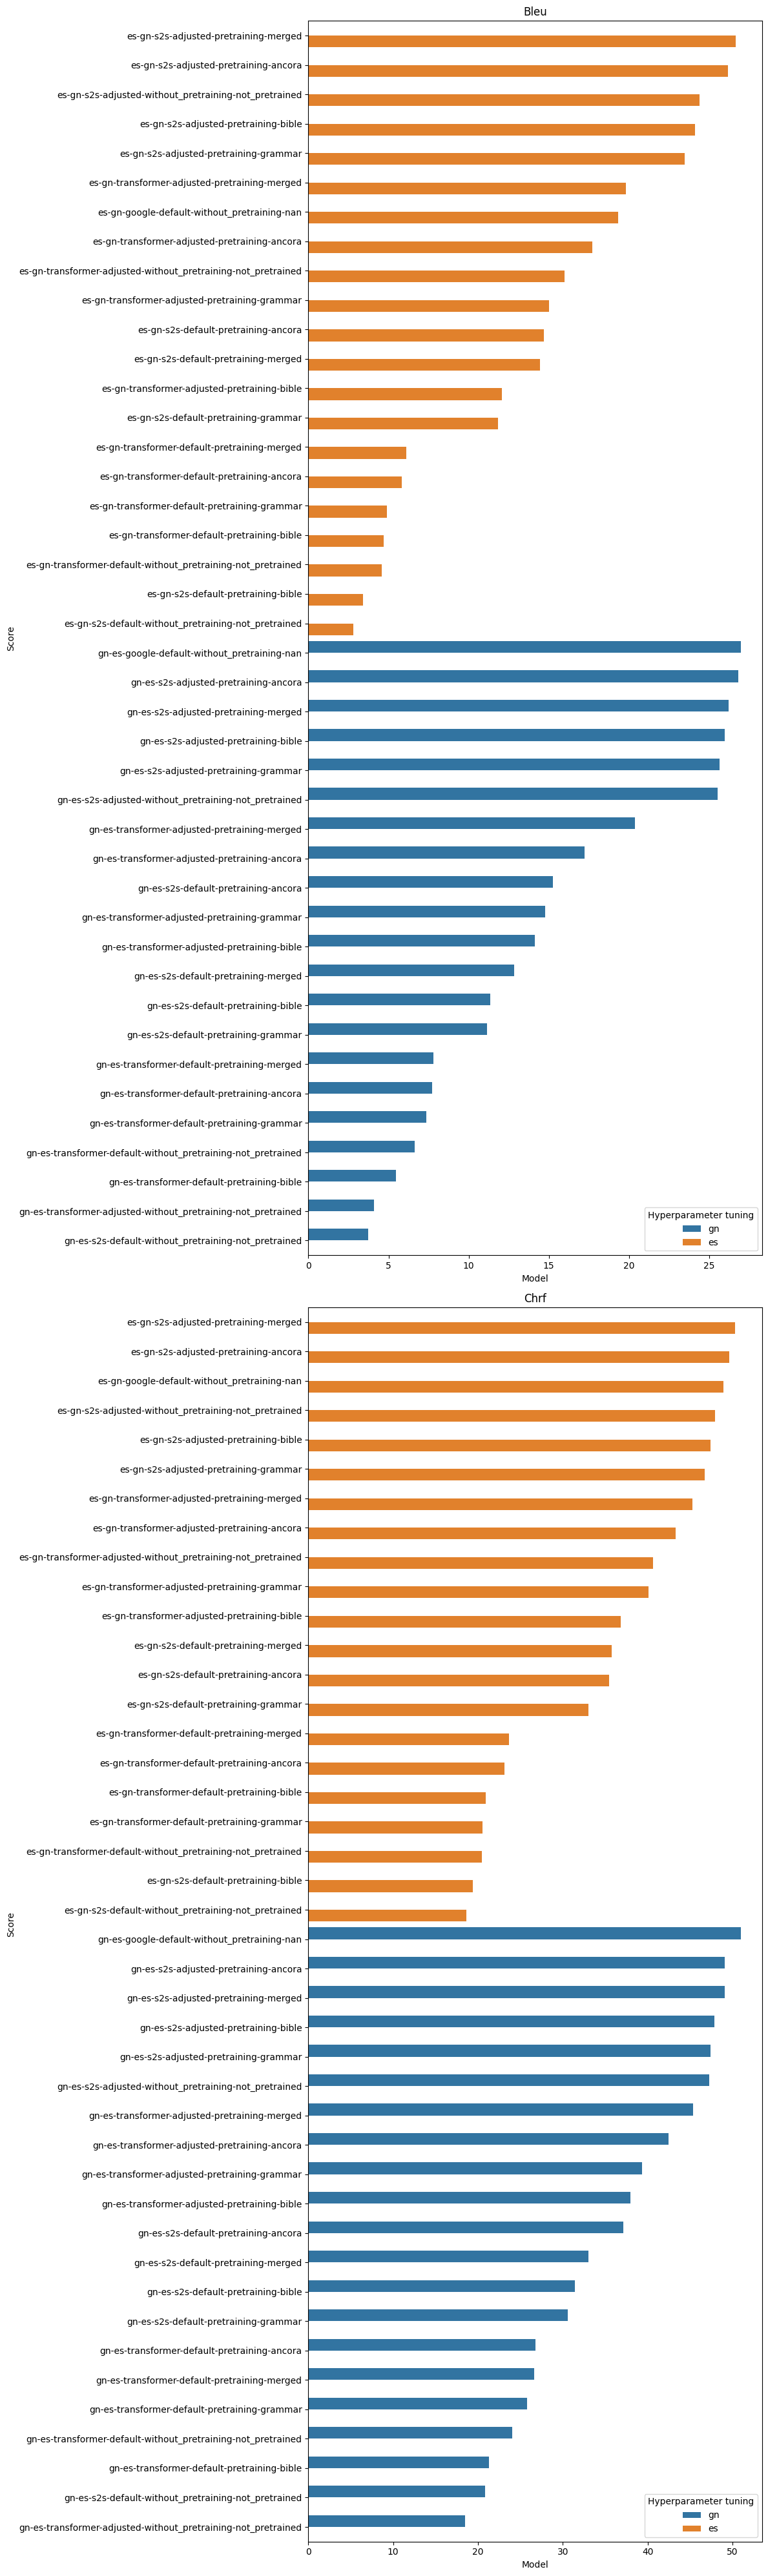

In [13]:
plot_global_scores(df)

### **1.3 Technique Comparison**

The test set involved the following methods:
- Model source: `{ours, google}`
- Model architectures: `{seq2seq, transformers}`
- Pretraining corpus: `{None, grammar, ancora, bible, merged}`
- Hyperparameter tuning: `{adjusted, default}`

In [14]:
def plot_technique_comparison(technique: str):
    fig, ax = plt.subplots(figsize=(15, 6), ncols=2)
    sns.boxplot(x='source', y='sacrebleu_corpus_bleu', 
                    hue=technique,
                    data=df[df['architecture'] != 'google'],
                    ax=ax[0])
    sns.boxplot(x='source', y='sacrebleu_corpus_chrf', 
                    hue=technique,
                    data=df[df['architecture'] != 'google'],
                    ax=ax[1])
    plt.show()

#### **1.3.1. Architecture Comparison**

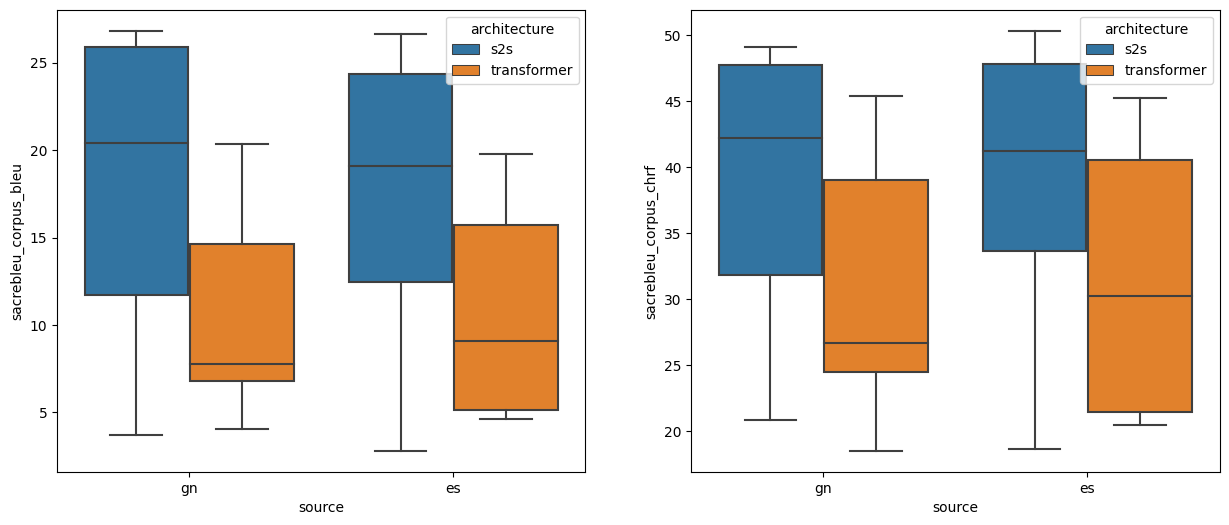

In [15]:
plot_technique_comparison(technique='architecture')

#### **1.3.2. Hyperparameter tuning Comparison**

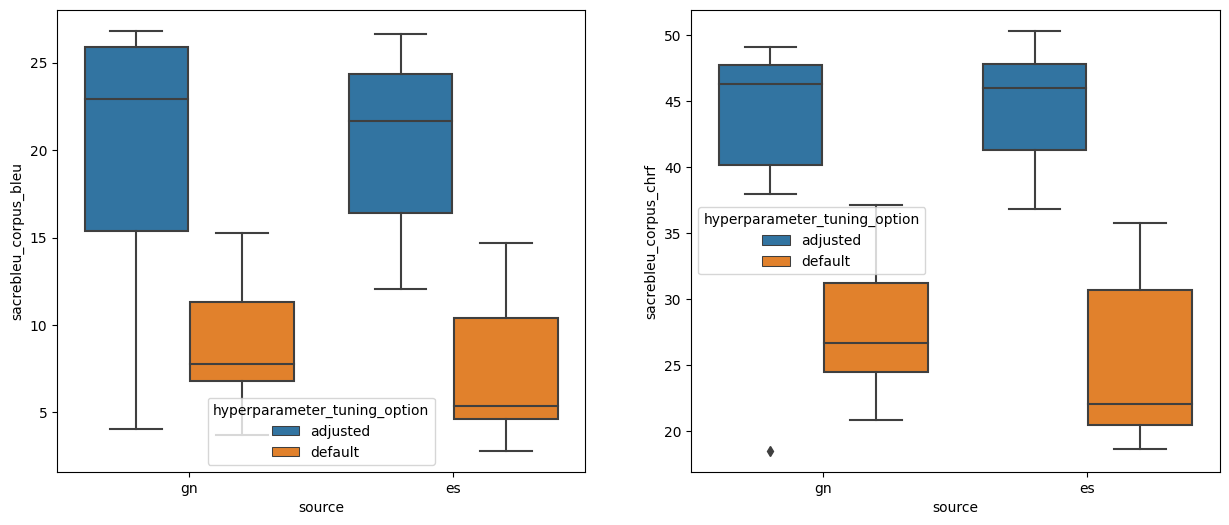

In [16]:
plot_technique_comparison(technique='hyperparameter_tuning_option')

#### **1.3.3. Hyperparameter tuning Comparison**

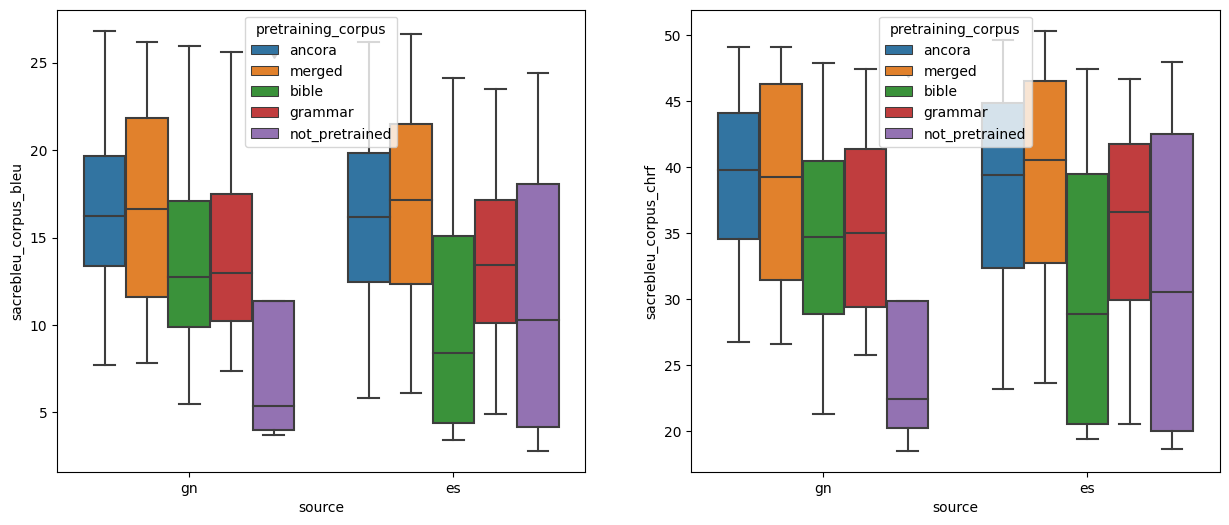

In [17]:
plot_technique_comparison(technique='pretraining_corpus')

## **2. Subset Metrics**

In [18]:
def create_bleu_scores_df(references, translated, bleu_score_types):
    bleu_scores_df = {'reference': [], 
                      'translation': [], 
                      'metric': [], 
                      'score': []}

    for reference, translation in zip(references, translated):
        for bleu_score_type in bleu_score_types:
            bleu_score = metrics.calculate_sacrebleu_sentence(reference, 
                                                translation, 
                                                metric=bleu_score_type)
            bleu_scores_df['reference'].append(reference)
            bleu_scores_df['translation'].append(translation)
            bleu_scores_df['metric'].append(bleu_score_type)
            bleu_scores_df['score'].append(bleu_score)

    return pd.DataFrame(bleu_scores_df)

In [19]:
def get_file_lines(filepath: str, ensure_length=None):
    lines = []
    with open(str(filepath), 'r', encoding='utf-8') as f:
        lines = f.readlines()

    lines = [line[:-1] if line.endswith('\n') else line for line in lines]

    if ensure_length is not None and len(lines) == ensure_length - 1:
        lines = lines + ['']

    return lines

In [20]:
test_gn_filelines = get_file_lines(real_test_set_template.format(trg='gn'))
test_es_filelines = get_file_lines(real_test_set_template.format(trg='es'))
test_length = len(test_gn_filelines)
df['filelines'] = df.apply(lambda row: \
                              get_file_lines(row['filepath'], ensure_length=test_length) if not pd.isna(row['filepath']) else \
                              get_file_lines(GOOGLE_TEST_GN_ES) if row['architecture'] == 'google' and row['source'] == 'gn' else \
                              get_file_lines(GOOGLE_TEST_ES_GN) if row['architecture'] == 'google' and row['source'] == 'es' else \
                              None, 
                           axis=1)

In [21]:
jojajovai_df = pd.read_csv(JOJAJOVAI_DIR)
jojajovai_test_df = jojajovai_df[jojajovai_df['split'] == 'test']
jojajovai_test_df.head()

split source                                                 gn  \
25521  test    abc                                Ko'ágã Cartes turno   
25522  test    abc  Movilización ciudadana oñembyaty ko'ã tendáre ...   
25523  test    abc  Ko'ã manifestante omoî iñakãre ome'ê Yasyretã ...   
25524  test    abc  Tavaygua ko'ã ary oñembyatýva calle España ha ...   
25525  test    abc  Ojehecha despliegue policial ohapejokóva manif...   

                                                      es  \
25521                        Ahora es el turno de Cartes   
25522  La movilización ciudadana se concentra hoy en ...   
25523  Los manifestantes lo responsabilizan de entreg...   
25524  Los ciudadanos de todas las edades se congrega...   
25525  Un importante despliegue policial impidió que ...   

                                               tokens_gn  \
25521                                Ko'ágã Cartes turno   
25522  Movilización ciudadana oñembyaty ko'ã tendáre ...   
25523  Ko'ã manifestante omoî iñakãre ome'ê Yasyretã ...   
25524  Tavaygua ko'ã ary oñembyatýva calle España ha ...   
25525  Ojehecha despliegue policial ohapejokóva manif...   

                                               tokens_es  
25521                        Ahora es el turno de Cartes  
25522  La movilización ciudadana se concentra hoy en ...  
25523  Los manifestantes lo responsabilizan de entreg...  
25524  Los ciudadanos de todas las edades se congrega...  
25525  Un importante despliegue policial impidió que ...

In [22]:
last_source_indices = jojajovai_test_df.groupby(['source']).last()['es'].tolist()
last_source_indices = [test_es_filelines.index(line) for line in last_source_indices]
source_names = jojajovai_test_df['source'].unique().tolist()
source_names

['abc',
 'anlp',
 'blogs',
 'hackaton',
 'libro_gn',
 'libro_td',
 'seminario',
 'spl']

### **2.1 By Corpus Subset**

#### **2.1.1. Subset Length**

One of the main purposes of using pretraining with a grammar was to test whether
using data augmentation for small sentence pairs would enhance translation
quality significantly.

In [23]:
def extract_subset_statistics(source_indices: list[int],
                              last_source_indices: list[int],
                              source_names: list[str],
                              test_gn_filelines: list[str]=test_gn_filelines,
                              test_es_filelines: list[str]=test_es_filelines,
                              plot=True):
    if plot:
        fig, ax = plt.subplots(ncols=len(last_source_indices) // 2, 
                               nrows=2, 
                               figsize=(4*len(last_source_indices), 12))

    current_statistics = collections.defaultdict(list)
    for (start_idx, end_idx), dataset_source in zip(zip(source_indices, 
                                                        last_source_indices),
                                                        source_names):
        subset_gn = test_gn_filelines[start_idx:end_idx+1]
        subset_es = test_es_filelines[start_idx:end_idx+1]
        tokenized_gn = [line.split() for line in subset_gn]
        tokenized_es = [line.split() for line in subset_es]
        tokenized_len_gn = [len(tokens) for tokens in tokenized_gn]
        tokenized_len_es = [len(tokens) for tokens in tokenized_es]

        current_statistics['source'].append(dataset_source)
        current_statistics['source_length'].append(len(subset_gn))
        current_statistics['target_length'].append(len(subset_es))
        current_statistics['source_word_length_median'].append(statistics.median(tokenized_len_gn))
        current_statistics['target_word_length_median'].append(statistics.median(tokenized_len_es))
        current_statistics['source_word_length_mean'].append(statistics.mean(tokenized_len_gn))
        current_statistics['target_word_length_mean'].append(statistics.mean(tokenized_len_es))
        current_statistics['source_word_length_std'].append(statistics.stdev(tokenized_len_gn))
        current_statistics['target_word_length_std'].append(statistics.stdev(tokenized_len_es))

        if plot:
            plot_idx = source_indices.index(start_idx)
            current_ax = ax[plot_idx % 2, plot_idx // 2]
            current_ax.set_title(f'{dataset_source}')
            sns.histplot(tokenized_len_gn, ax=current_ax, color='red', label='source')
            sns.histplot(tokenized_len_es, ax=current_ax, color='blue', label='target')
            current_ax.legend()



    return pd.DataFrame(current_statistics)

In [24]:
def extract_subset_scores(df: pd.DataFrame,
                          source_indices: list[int], 
                          last_source_indices: list[int], 
                          source_names: list[str],
                          score_types: list[str]=score_types,
                          test_gn_filelines: list[str]=test_gn_filelines,
                          test_es_filelines: list[str]=test_es_filelines):
    for metric in score_types:
        for (start_idx, end_idx), dataset_source in zip(zip(source_indices, 
                                                            last_source_indices),
                                                        source_names):
            current_scores = []
            for idx, current_rows in df.iterrows():
                current_filelines = current_rows['filelines']
                test_filelines = test_gn_filelines if current_rows['target'] == 'gn' else test_es_filelines
                current_reference_split = test_filelines[start_idx:end_idx+1]
                current_translation_split = current_filelines[start_idx:end_idx+1]

                if len(current_reference_split) != len(current_translation_split):
                    print(f'WARNING: reference length: {len(current_reference_split)} != current length: {len(current_translation_split)}')
                    current_scores.append(None)
                    continue

                source_score_column = f'{metric}-{dataset_source}'
                current_score = metrics.calculate_metric(current_reference_split, 
                                                        current_translation_split, 
                                                        metric)
                current_scores.append(current_score)
                print(f'{source_score_column}: {current_score}')
            df[source_score_column] = current_scores
    return df

sacrebleu_corpus_bleu-abc: 30.811133853242815
sacrebleu_corpus_bleu-abc: 30.834268733945855
sacrebleu_corpus_bleu-abc: 30.056239358669664
sacrebleu_corpus_bleu-abc: 28.74397732131535
sacrebleu_corpus_bleu-abc: 29.099799077048406
sacrebleu_corpus_bleu-abc: 28.393501462514973
sacrebleu_corpus_bleu-abc: 22.72166108481143
sacrebleu_corpus_bleu-abc: 18.53130536522373
sacrebleu_corpus_bleu-abc: 17.12440691784945
sacrebleu_corpus_bleu-abc: 15.025675562699215
sacrebleu_corpus_bleu-abc: 14.202333473364195
sacrebleu_corpus_bleu-abc: 14.018518473928323
sacrebleu_corpus_bleu-abc: 12.148749798711334
sacrebleu_corpus_bleu-abc: 11.822015637828668
sacrebleu_corpus_bleu-abc: 7.355462564592504
sacrebleu_corpus_bleu-abc: 7.200525157527486
sacrebleu_corpus_bleu-abc: 6.73839357194139
sacrebleu_corpus_bleu-abc: 6.0290984553396045
sacrebleu_corpus_bleu-abc: 4.622654507202785
sacrebleu_corpus_bleu-abc: 2.7268462703246508
sacrebleu_corpus_bleu-abc: 2.1044159391112807
sacrebleu_corpus_bleu-abc: 31.4549028632675

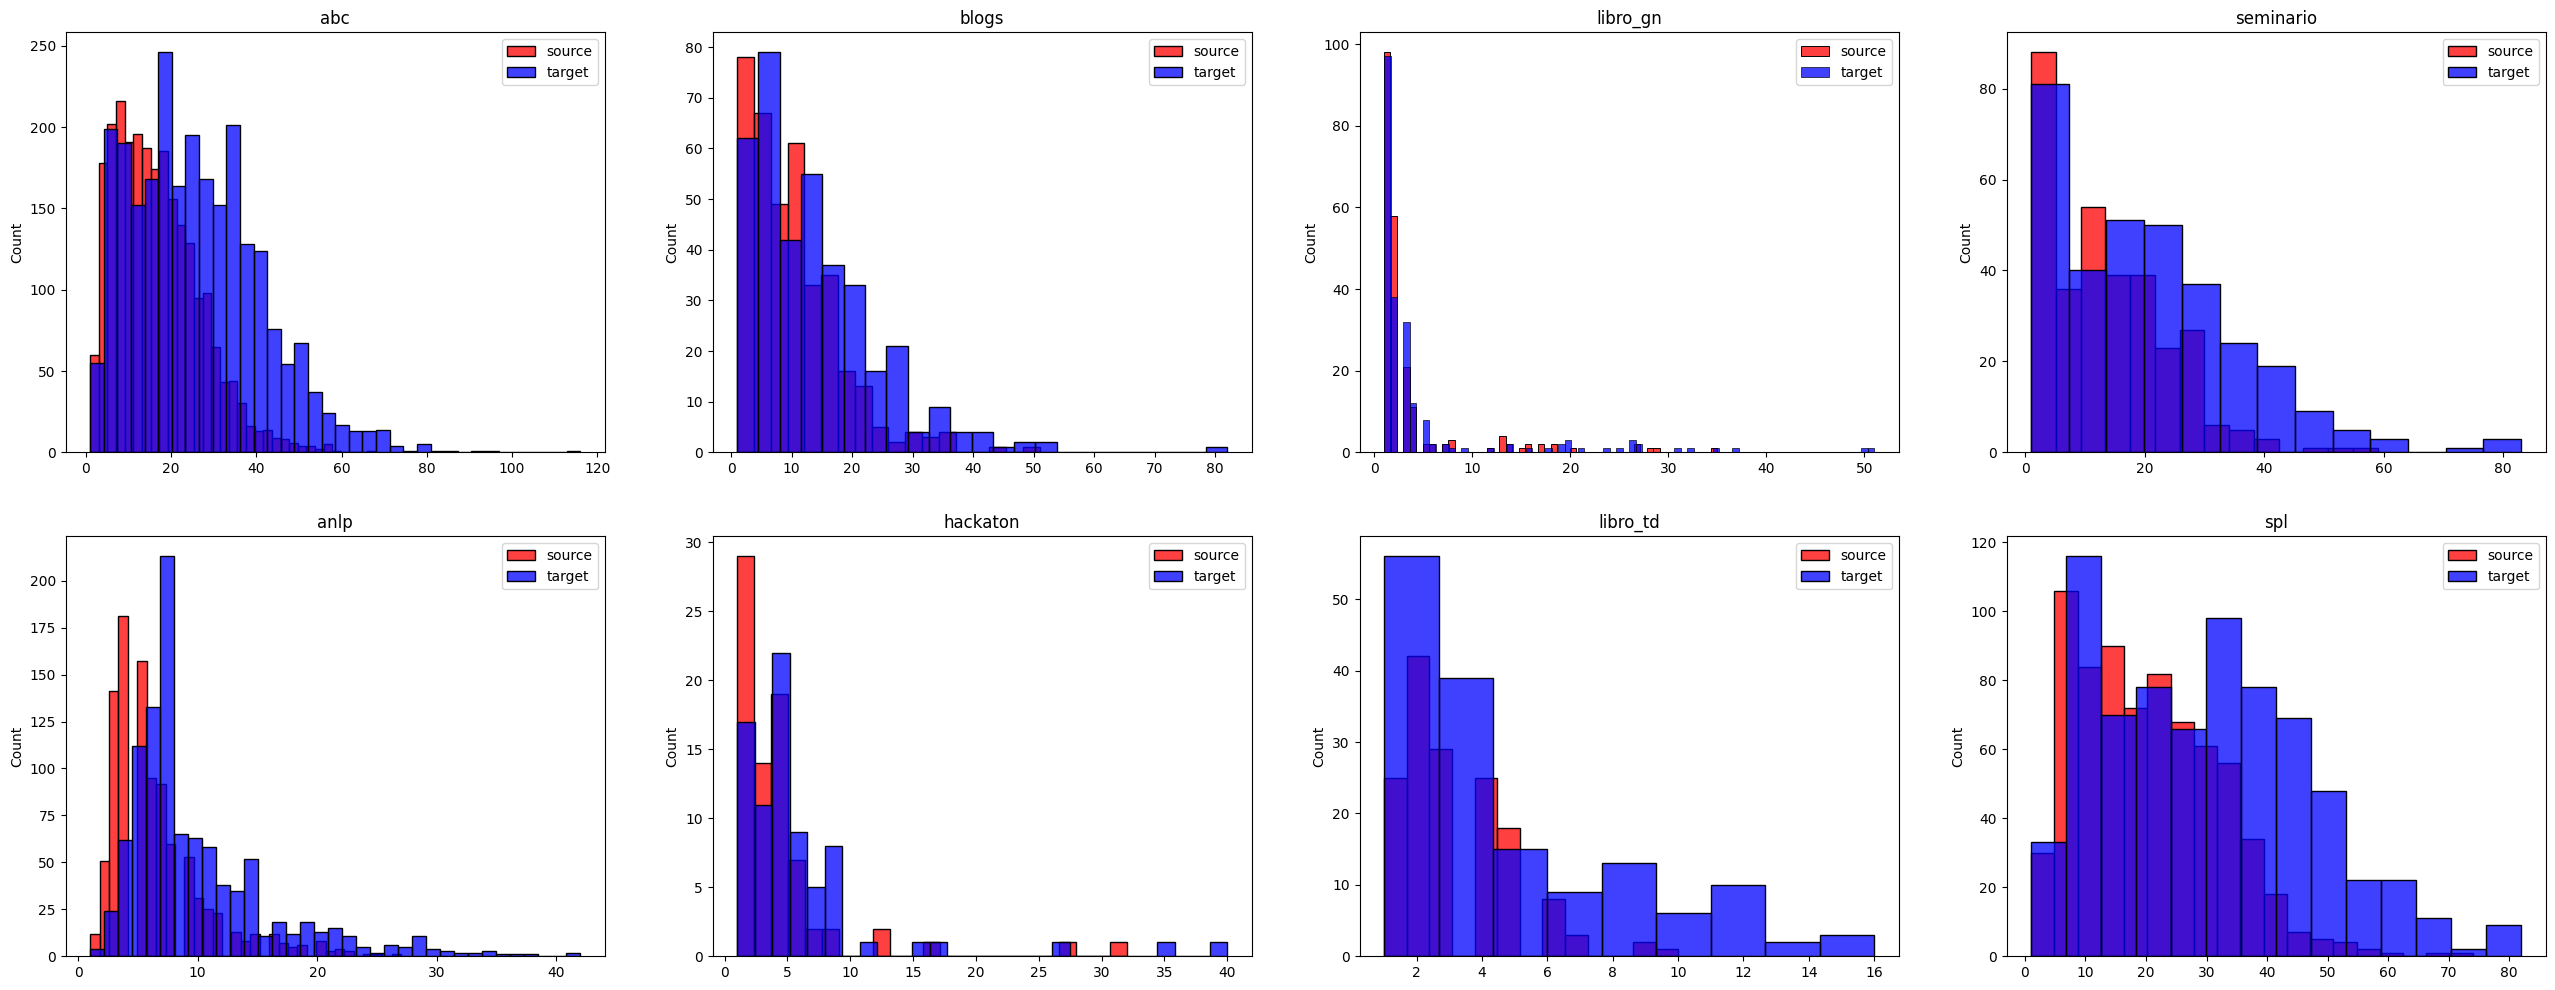

In [25]:
source_indices = [0] + last_source_indices

if not CACHE or not exists_test_set_csv:
    df = extract_subset_scores(df, 
                               source_indices, 
                               last_source_indices, 
                               source_names)

subset_statistics_df = extract_subset_statistics(source_indices, 
                                                 last_source_indices, 
                                                 source_names)

In [26]:
subset_statistics_df.sort_values(by=['target_word_length_median'])

source  source_length  target_length  source_word_length_median  \
4   libro_gn            217            217                        2.0   
5   libro_td            153            153                        3.0   
3   hackaton             78             78                        3.0   
1       anlp           1005           1005                        5.0   
2      blogs            372            372                        9.0   
6  seminario            323            323                       12.0   
0        abc           2472           2472                       16.0   
7        spl            722            722                       20.0   

   target_word_length_median  source_word_length_mean  \
4                        2.0                 3.483871   
5                        3.0                 3.156863   
3                        4.0                 4.487179   
1                        8.0                 6.477612   
2                       12.0                10.190860   
6                       18.0                13.619195   
0                       25.0                17.051375   
7                       29.0                20.411357   

   target_word_length_mean  source_word_length_std  target_word_length_std  
4                 4.654378                5.424649                8.161869  
5                 4.633987                1.770064                3.608746  
3                 5.897436                4.922104                6.427598  
1                10.043781                4.109646                6.256317  
2                13.908602                7.647110               10.558640  
6                20.331269               10.092455               15.692855  
0                26.034385                9.881255               15.187857  
7                29.826870               11.658860               17.075234

**Observation:** The corpus with the lowest word length are:
- libro_gn
- libro_td
- hackaton

#### **2.1.2 Subset Scores**

In [27]:
df = df.sort_index(axis=1).sort_values(by=['source', 'sacrebleu_corpus_bleu'], ascending=False)
df.drop(labels=['filelines'], axis=1).to_csv(TEST_SET_CSV_FILEPATH, index=False)
light_weight_df = df.drop(labels=['filelines', 'filepath'], axis=1)
light_weight_df

architecture hyperparameter_tuning_option  \
0        google                      default   
21          s2s                     adjusted   
23          s2s                     adjusted   
22          s2s                     adjusted   
20          s2s                     adjusted   
28          s2s                     adjusted   
3   transformer                     adjusted   
1   transformer                     adjusted   
25          s2s                      default   
0   transformer                     adjusted   
2   transformer                     adjusted   
27          s2s                      default   
26          s2s                      default   
24          s2s                      default   
7   transformer                      default   
5   transformer                      default   
4   transformer                      default   
9   transformer                      default   
6   transformer                      default   
8   transformer                     adjusted   
29          s2s                      default   
33          s2s                     adjusted   
31          s2s                     adjusted   
38          s2s                     adjusted   
32          s2s                     adjusted   
30          s2s                     adjusted   
13  transformer                     adjusted   
1        google                      default   
11  transformer                     adjusted   
18  transformer                     adjusted   
10  transformer                     adjusted   
35          s2s                      default   
37          s2s                      default   
12  transformer                     adjusted   
34          s2s                      default   
17  transformer                      default   
15  transformer                      default   
14  transformer                      default   
16  transformer                      default   
19  transformer                      default   
36          s2s                      default   
39          s2s                      default   

                                             model_id pretraining_corpus  \
0        gn-es-google-default-without_pretraining-nan                NaN   
21              gn-es-s2s-adjusted-pretraining-ancora             ancora   
23              gn-es-s2s-adjusted-pretraining-merged             merged   
22               gn-es-s2s-adjusted-pretraining-bible              bible   
20             gn-es-s2s-adjusted-pretraining-grammar            grammar   
28  gn-es-s2s-adjusted-without_pretraining-not_pre...     not_pretrained   
3       gn-es-transformer-adjusted-pretraining-merged             merged   
1       gn-es-transformer-adjusted-pretraining-ancora             ancora   
25               gn-es-s2s-default-pretraining-ancora             ancora   
0      gn-es-transformer-adjusted-pretraining-grammar            grammar   
2        gn-es-transformer-adjusted-pretraining-bible              bible   
27               gn-es-s2s-default-pretraining-merged             merged   
26                gn-es-s2s-default-pretraining-bible              bible   
24              gn-es-s2s-default-pretraining-grammar            grammar   
7        gn-es-transformer-default-pretraining-merged             merged   
5        gn-es-transformer-default-pretraining-ancora             ancora   
4       gn-es-transformer-default-pretraining-grammar            grammar   
9   gn-es-transformer-default-without_pretraining-...     not_pretrained   
6         gn-es-transformer-default-pretraining-bible              bible   
8   gn-es-transformer-adjusted-without_pretraining...     not_pretrained   
29  gn-es-s2s-default-without_pretraining-not_pret...     not_pretrained   
33              es-gn-s2s-adjusted-pretraining-merged             merged   
31              es-gn-s2s-adjusted-pretraining-ancora             ancora   
38  es-gn-s2s-adjusted-without_pretraining-not_pre...     not_pretrained   
32               es-gn-s2s-adjusted-pr

In [28]:
identifier_columns = ['source', 'target', 'architecture', 'hyperparameter_tuning_option', 'pretraining_corpus', 'pretraining_option']

In [29]:
def extract_metric_from_subset(df: pd.DataFrame,
                               subset: str, 
                               metrics: list[str], 
                               identifier_columns=identifier_columns, 
                               sort=True):
    metric_columns = [f'{metric}-{subset}' for metric in metrics]
    metric_columns = [[metrics[i], metric_columns[i]] for i in range(len(metrics))]
    metric_columns = sum(metric_columns, [])
    current_df = df[identifier_columns + metric_columns]

    if sort:
        current_df = current_df.sort_values(['source', metric_columns[1]], ascending=False)
        
    return current_df

In [30]:
def create_pretraining_pairs_df(pair_rows: list[pd.Series], subset: str):
    pair_data = []
    for grammar_row, no_pretraining_row in pair_rows:
        for metric in ['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf']:
            metric = metric + '-' + subset
            grammar_score = grammar_row[metric]
            no_pretraining_score = no_pretraining_row[metric]
            improvement = grammar_score - no_pretraining_score
            pair_data.append({
                'source': grammar_row['source'],
                'target': grammar_row['target'],
                'architecture': grammar_row['architecture'],
                'hyperparameter_tuning_option': grammar_row['hyperparameter_tuning_option'],
                'metric': metric,
                'improvement': improvement
            })
    return pair_data
        

def match_pretraining_enhancement(pretraining_corpus: str, subset: str):
    grammar_df = light_weight_df[(light_weight_df['pretraining_corpus']==pretraining_corpus) | 
                                (light_weight_df['pretraining_option']=='without_pretraining')]
    grammar_df['model_id'] = grammar_df['model_id'].cat.remove_unused_categories()

    pair_rows = []
    for _, grammar_row in grammar_df.iterrows():
        if grammar_row['pretraining_corpus'] != pretraining_corpus:
            continue

        for _, no_pretraining_row in grammar_df.iterrows():
            if no_pretraining_row['pretraining_corpus'] != 'not_pretrained':
                continue

            if grammar_row['source'] != no_pretraining_row['source']:
                continue

            if grammar_row['architecture'] != no_pretraining_row['architecture']:
                continue

            if grammar_row['hyperparameter_tuning_option'] != no_pretraining_row['hyperparameter_tuning_option']:
                continue

            pair_rows.append((grammar_row, no_pretraining_row))

    pair_data = create_pretraining_pairs_df(pair_rows, subset)
    pair_df = pd.DataFrame(pair_data)
    pair_df['model_id'] = pair_df['source'] + '-' + pair_df['target'] + '-' + pair_df['architecture'] + '-' + pair_df['hyperparameter_tuning_option']

    return pair_df

##### **2.1.2.1. ABC**

In [31]:
current_df = extract_metric_from_subset(light_weight_df, 'abc', ['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'])
current_df

source target architecture hyperparameter_tuning_option pretraining_corpus  \
21     gn     es          s2s                     adjusted             ancora   
0      gn     es       google                      default                NaN   
23     gn     es          s2s                     adjusted             merged   
20     gn     es          s2s                     adjusted            grammar   
22     gn     es          s2s                     adjusted              bible   
28     gn     es          s2s                     adjusted     not_pretrained   
3      gn     es  transformer                     adjusted             merged   
1      gn     es  transformer                     adjusted             ancora   
25     gn     es          s2s                      default             ancora   
0      gn     es  transformer                     adjusted            grammar   
2      gn     es  transformer                     adjusted              bible   
27     gn     es          s2s                      default             merged   
26     gn     es          s2s                      default              bible   
24     gn     es          s2s                      default            grammar   
7      gn     es  transformer                      default             merged   
5      gn     es  transformer                      default             ancora   
4      gn     es  transformer                      default            grammar   
9      gn     es  transformer                      default     not_pretrained   
6      gn     es  transformer                      default              bible   
8      gn     es  transformer                     adjusted     not_pretrained   
29     gn     es          s2s                      default     not_pretrained   
33     es     gn          s2s                     adjusted             merged   
31     es     gn          s2s                     adjusted             ancora   
38     es     gn          s2s                     adjusted     not_pretrained   
32     es     gn          s2s                     adjusted              bible   
30     es     gn          s2s                     adjusted            grammar   
1      es     gn       google                      default                NaN   
13     es     gn  transformer                     adjusted             merged   
11     es     gn  transformer                     adjusted             ancora   
35     es     gn          s2s                      default             ancora   
18     es     gn  transformer                     adjusted     not_pretrained   
10     es     gn  transformer                     adjusted            grammar   
37     es     gn          s2s                      default             merged   
34     es     gn          s2s                      default            grammar   
12     es     gn  transformer                     adjusted              bible   
17     es     gn  transformer                      default             merged   
15     es     gn  transformer                      default             ancora   
14     es     gn  transformer                      default            grammar   
19     es     gn  transformer                      default     not_pretrained   
16     es     gn  transformer                      default              bible   
36     es     gn          s2s                      default              bible   
39     es     gn          s2s                      default     not_pretrained   

     pretraining_option  sacrebleu_corpus_bleu  sacrebleu_corpus_bleu-abc  \
21          pretraining               26.83030                  30.834269   
0   without_pretraining               26.96010                  30.811134   
23          pretraining               26.20430                  30.056239   
20          pretraining               25.63350                  29.099799   
22          pretraining               25.97270                  28.743977   
28  without_pretraining               25.53190           

##### **2.1.2.2. ANLP**

In [32]:
current_df = extract_metric_from_subset(light_weight_df, 'anlp', ['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'])
current_df

source target architecture hyperparameter_tuning_option pretraining_corpus  \
0      gn     es       google                      default                NaN   
23     gn     es          s2s                     adjusted             merged   
21     gn     es          s2s                     adjusted             ancora   
3      gn     es  transformer                     adjusted             merged   
20     gn     es          s2s                     adjusted            grammar   
22     gn     es          s2s                     adjusted              bible   
28     gn     es          s2s                     adjusted     not_pretrained   
25     gn     es          s2s                      default             ancora   
1      gn     es  transformer                     adjusted             ancora   
0      gn     es  transformer                     adjusted            grammar   
2      gn     es  transformer                     adjusted              bible   
27     gn     es          s2s                      default             merged   
7      gn     es  transformer                      default             merged   
24     gn     es          s2s                      default            grammar   
4      gn     es  transformer                      default            grammar   
26     gn     es          s2s                      default              bible   
5      gn     es  transformer                      default             ancora   
6      gn     es  transformer                      default              bible   
9      gn     es  transformer                      default     not_pretrained   
29     gn     es          s2s                      default     not_pretrained   
8      gn     es  transformer                     adjusted     not_pretrained   
1      es     gn       google                      default                NaN   
33     es     gn          s2s                     adjusted             merged   
31     es     gn          s2s                     adjusted             ancora   
32     es     gn          s2s                     adjusted              bible   
13     es     gn  transformer                     adjusted             merged   
30     es     gn          s2s                     adjusted            grammar   
38     es     gn          s2s                     adjusted     not_pretrained   
11     es     gn  transformer                     adjusted             ancora   
10     es     gn  transformer                     adjusted            grammar   
37     es     gn          s2s                      default             merged   
35     es     gn          s2s                      default             ancora   
18     es     gn  transformer                     adjusted     not_pretrained   
12     es     gn  transformer                     adjusted              bible   
17     es     gn  transformer                      default             merged   
34     es     gn          s2s                      default            grammar   
14     es     gn  transformer                      default            grammar   
15     es     gn  transformer                      default             ancora   
16     es     gn  transformer                      default              bible   
19     es     gn  transformer                      default     not_pretrained   
36     es     gn          s2s                      default              bible   
39     es     gn          s2s                      default     not_pretrained   

     pretraining_option  sacrebleu_corpus_bleu  sacrebleu_corpus_bleu-anlp  \
0   without_pretraining               26.96010                   19.804009   
23          pretraining               26.20430                    4.325033   
21          pretraining               26.83030                    4.037449   
3           pretraining               20.36690                    3.179696   
20          pretraining               25.63350                    3.063856   
22          pretraining               25.97270     

##### **2.1.2.3. blogs**

In [33]:
current_df = extract_metric_from_subset(light_weight_df, 'blogs', ['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'])
current_df

source target architecture hyperparameter_tuning_option pretraining_corpus  \
0      gn     es       google                      default                NaN   
23     gn     es          s2s                     adjusted             merged   
21     gn     es          s2s                     adjusted             ancora   
22     gn     es          s2s                     adjusted              bible   
28     gn     es          s2s                     adjusted     not_pretrained   
20     gn     es          s2s                     adjusted            grammar   
3      gn     es  transformer                     adjusted             merged   
1      gn     es  transformer                     adjusted             ancora   
0      gn     es  transformer                     adjusted            grammar   
25     gn     es          s2s                      default             ancora   
2      gn     es  transformer                     adjusted              bible   
27     gn     es          s2s                      default             merged   
24     gn     es          s2s                      default            grammar   
26     gn     es          s2s                      default              bible   
4      gn     es  transformer                      default            grammar   
5      gn     es  transformer                      default             ancora   
7      gn     es  transformer                      default             merged   
9      gn     es  transformer                      default     not_pretrained   
6      gn     es  transformer                      default              bible   
29     gn     es          s2s                      default     not_pretrained   
8      gn     es  transformer                     adjusted     not_pretrained   
1      es     gn       google                      default                NaN   
33     es     gn          s2s                     adjusted             merged   
31     es     gn          s2s                     adjusted             ancora   
30     es     gn          s2s                     adjusted            grammar   
32     es     gn          s2s                     adjusted              bible   
38     es     gn          s2s                     adjusted     not_pretrained   
13     es     gn  transformer                     adjusted             merged   
11     es     gn  transformer                     adjusted             ancora   
10     es     gn  transformer                     adjusted            grammar   
18     es     gn  transformer                     adjusted     not_pretrained   
35     es     gn          s2s                      default             ancora   
37     es     gn          s2s                      default             merged   
12     es     gn  transformer                     adjusted              bible   
34     es     gn          s2s                      default            grammar   
17     es     gn  transformer                      default             merged   
15     es     gn  transformer                      default             ancora   
19     es     gn  transformer                      default     not_pretrained   
16     es     gn  transformer                      default              bible   
14     es     gn  transformer                      default            grammar   
36     es     gn          s2s                      default              bible   
39     es     gn          s2s                      default     not_pretrained   

     pretraining_option  sacrebleu_corpus_bleu  sacrebleu_corpus_bleu-blogs  \
0   without_pretraining               26.96010                    24.445486   
23          pretraining               26.20430                    18.442991   
21          pretraining               26.83030                    18.128379   
22          pretraining               25.97270                    17.220267   
28  without_pretraining               25.53190                    16.094188   
20          pretraining               25.6335

##### **2.1.2.4. Hackaton (Short sentence pairs)**

In [34]:
current_df = extract_metric_from_subset(light_weight_df, 'hackaton', ['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'])
current_df

source target architecture hyperparameter_tuning_option pretraining_corpus  \
0      gn     es       google                      default                NaN   
23     gn     es          s2s                     adjusted             merged   
28     gn     es          s2s                     adjusted     not_pretrained   
20     gn     es          s2s                     adjusted            grammar   
21     gn     es          s2s                     adjusted             ancora   
3      gn     es  transformer                     adjusted             merged   
22     gn     es          s2s                     adjusted              bible   
27     gn     es          s2s                      default             merged   
0      gn     es  transformer                     adjusted            grammar   
1      gn     es  transformer                     adjusted             ancora   
25     gn     es          s2s                      default             ancora   
5      gn     es  transformer                      default             ancora   
4      gn     es  transformer                      default            grammar   
9      gn     es  transformer                      default     not_pretrained   
7      gn     es  transformer                      default             merged   
2      gn     es  transformer                     adjusted              bible   
24     gn     es          s2s                      default            grammar   
26     gn     es          s2s                      default              bible   
6      gn     es  transformer                      default              bible   
29     gn     es          s2s                      default     not_pretrained   
8      gn     es  transformer                     adjusted     not_pretrained   
1      es     gn       google                      default                NaN   
33     es     gn          s2s                     adjusted             merged   
38     es     gn          s2s                     adjusted     not_pretrained   
31     es     gn          s2s                     adjusted             ancora   
30     es     gn          s2s                     adjusted            grammar   
34     es     gn          s2s                      default            grammar   
14     es     gn  transformer                      default            grammar   
12     es     gn  transformer                     adjusted              bible   
13     es     gn  transformer                     adjusted             merged   
16     es     gn  transformer                      default              bible   
18     es     gn  transformer                     adjusted     not_pretrained   
10     es     gn  transformer                     adjusted            grammar   
17     es     gn  transformer                      default             merged   
11     es     gn  transformer                     adjusted             ancora   
32     es     gn          s2s                     adjusted              bible   
37     es     gn          s2s                      default             merged   
35     es     gn          s2s                      default             ancora   
39     es     gn          s2s                      default     not_pretrained   
15     es     gn  transformer                      default             ancora   
19     es     gn  transformer                      default     not_pretrained   
36     es     gn          s2s                      default              bible   

     pretraining_option  sacrebleu_corpus_bleu  \
0   without_pretraining               26.96010   
23          pretraining               26.20430   
28  without_pretraining               25.53190   
20          pretraining               25.63350   
21          pretraining               26.83030   
3           pretraining               20.36690   
22          pretraining               25.97270   
27          pretraining               12.84860   
0           pretraining               14.78390   
1           pretrai

In [35]:
pair_df = match_pretraining_enhancement(pretraining_corpus='grammar', subset='hackaton')
pair_df


source target architecture hyperparameter_tuning_option  \
0      gn     es          s2s                     adjusted   
1      gn     es          s2s                     adjusted   
2      gn     es  transformer                     adjusted   
3      gn     es  transformer                     adjusted   
4      gn     es          s2s                      default   
5      gn     es          s2s                      default   
6      gn     es  transformer                      default   
7      gn     es  transformer                      default   
8      es     gn          s2s                     adjusted   
9      es     gn          s2s                     adjusted   
10     es     gn  transformer                     adjusted   
11     es     gn  transformer                     adjusted   
12     es     gn          s2s                      default   
13     es     gn          s2s                      default   
14     es     gn  transformer                      default   
15     es     gn  transformer                      default   

                            metric  improvement                    model_id  
0   sacrebleu_corpus_bleu-hackaton    -1.205497          gn-es-s2s-adjusted  
1   sacrebleu_corpus_chrf-hackaton     0.231848          gn-es-s2s-adjusted  
2   sacrebleu_corpus_bleu-hackaton     6.328313  gn-es-transformer-adjusted  
3   sacrebleu_corpus_chrf-hackaton    13.670621  gn-es-transformer-adjusted  
4   sacrebleu_corpus_bleu-hackaton     1.826391           gn-es-s2s-default  
5   sacrebleu_corpus_chrf-hackaton     1.242237           gn-es-s2s-default  
6   sacrebleu_corpus_bleu-hackaton     0.013076   gn-es-transformer-default  
7   sacrebleu_corpus_chrf-hackaton     2.137138   gn-es-transformer-default  
8   sacrebleu_corpus_bleu-hackaton    -0.262846          es-gn-s2s-adjusted  
9   sacrebleu_corpus_chrf-hackaton     1.545776          es-gn-s2s-adjusted  
10  sacrebleu_corpus_bleu-hackaton    -0.073274  es-gn-transformer-adjusted  
11  sacrebleu_corpus_chrf-hackaton     2.174289  es-gn-transformer-adjusted  
12  sacrebleu_corpus_bleu-hackaton     1.557054           es-gn-s2s-default  
13  sacrebleu_corpus_chrf-hackaton     8.248393           es-gn-s2s-default  
14  sacrebleu_corpus_bleu-hackaton     1.612057   es-gn-transformer-default  
15  sacrebleu_corpus_chrf-hackaton     3.284423   es-gn-transformer-default

In [36]:
pair_df.describe()

improvement
count    16.000000
mean      2.645625
std       3.802942
min      -1.205497
25%       0.177155
50%       1.584555
75%       2.451822
max      13.670621

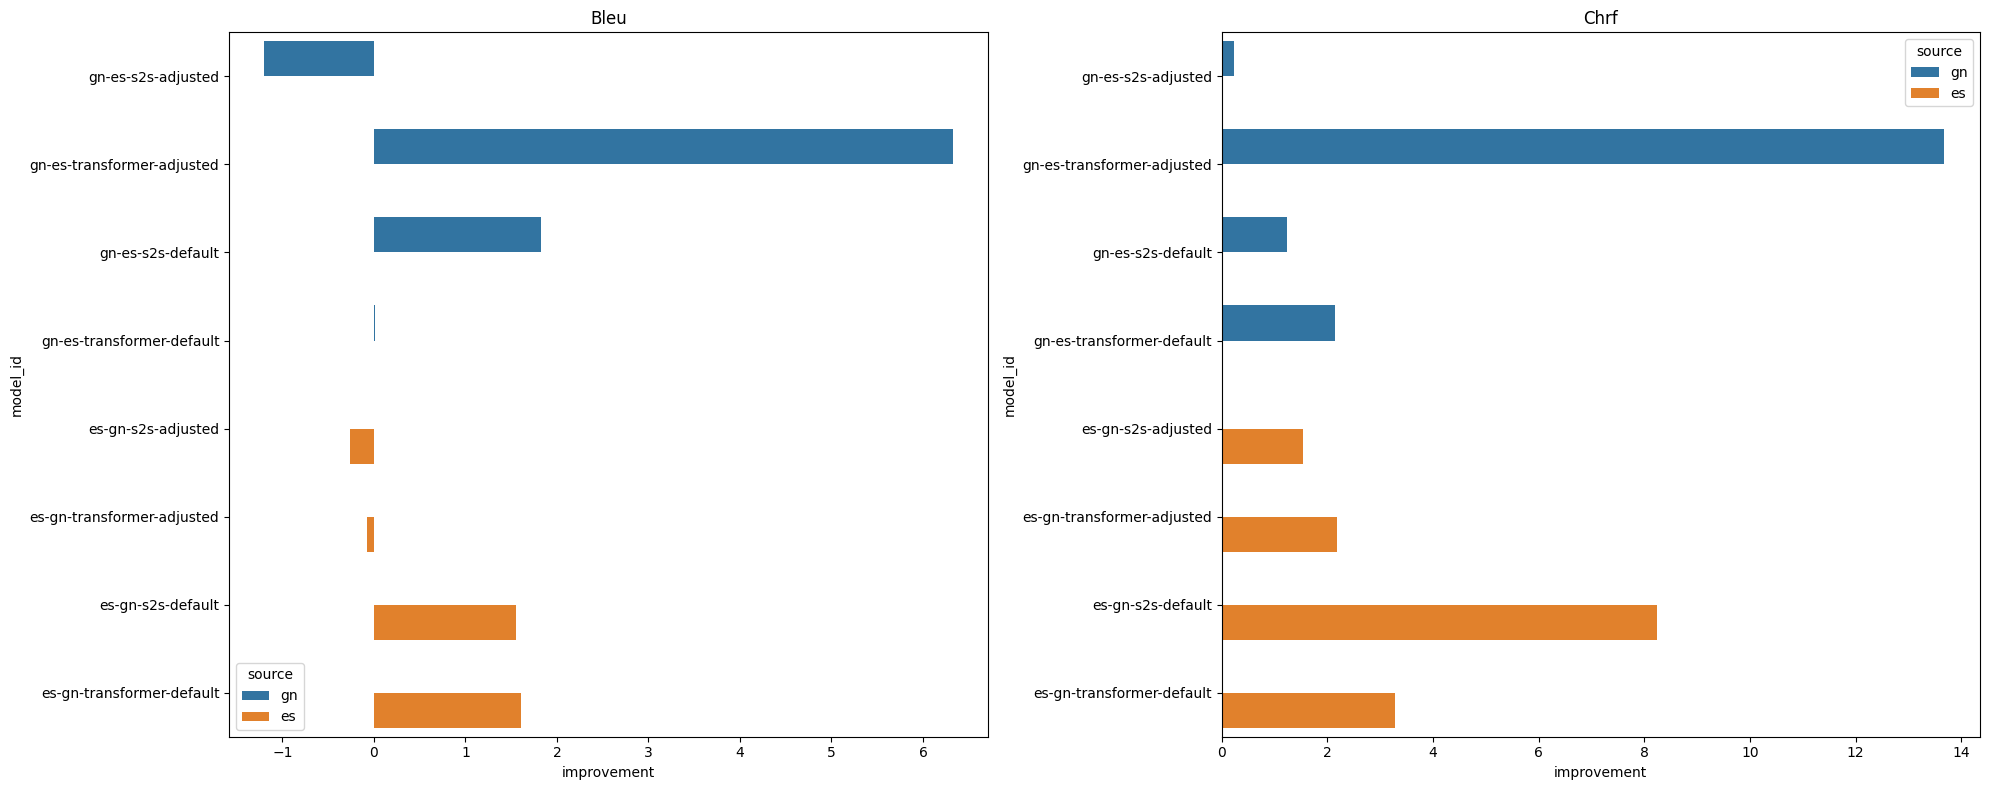

In [37]:
fig, ax = plt.subplots(figsize=(20, 8), ncols=2)
sns.barplot(y='model_id', x='improvement', hue='source', data=pair_df[pair_df['metric']=='sacrebleu_corpus_bleu-hackaton'], ax=ax[0]);
sns.barplot(y='model_id', x='improvement', hue='source', data=pair_df[pair_df['metric']=='sacrebleu_corpus_chrf-hackaton'], ax=ax[1]);

ax[0].set_title('Bleu')
ax[1].set_title('Chrf')
plt.tight_layout()

##### **2.1.2.5. libro_gn**

In [38]:
current_df = extract_metric_from_subset(light_weight_df, 'libro_gn', ['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'])
current_df

source target architecture hyperparameter_tuning_option pretraining_corpus  \
0      gn     es       google                      default                NaN   
22     gn     es          s2s                     adjusted              bible   
21     gn     es          s2s                     adjusted             ancora   
28     gn     es          s2s                     adjusted     not_pretrained   
23     gn     es          s2s                     adjusted             merged   
20     gn     es          s2s                     adjusted            grammar   
3      gn     es  transformer                     adjusted             merged   
25     gn     es          s2s                      default             ancora   
0      gn     es  transformer                     adjusted            grammar   
1      gn     es  transformer                     adjusted             ancora   
2      gn     es  transformer                     adjusted              bible   
24     gn     es          s2s                      default            grammar   
27     gn     es          s2s                      default             merged   
7      gn     es  transformer                      default             merged   
9      gn     es  transformer                      default     not_pretrained   
4      gn     es  transformer                      default            grammar   
5      gn     es  transformer                      default             ancora   
26     gn     es          s2s                      default              bible   
6      gn     es  transformer                      default              bible   
29     gn     es          s2s                      default     not_pretrained   
8      gn     es  transformer                     adjusted     not_pretrained   
31     es     gn          s2s                     adjusted             ancora   
38     es     gn          s2s                     adjusted     not_pretrained   
1      es     gn       google                      default                NaN   
33     es     gn          s2s                     adjusted             merged   
32     es     gn          s2s                     adjusted              bible   
30     es     gn          s2s                     adjusted            grammar   
13     es     gn  transformer                     adjusted             merged   
37     es     gn          s2s                      default             merged   
35     es     gn          s2s                      default             ancora   
34     es     gn          s2s                      default            grammar   
18     es     gn  transformer                     adjusted     not_pretrained   
11     es     gn  transformer                     adjusted             ancora   
10     es     gn  transformer                     adjusted            grammar   
14     es     gn  transformer                      default            grammar   
19     es     gn  transformer                      default     not_pretrained   
12     es     gn  transformer                     adjusted              bible   
17     es     gn  transformer                      default             merged   
15     es     gn  transformer                      default             ancora   
16     es     gn  transformer                      default              bible   
39     es     gn          s2s                      default     not_pretrained   
36     es     gn          s2s                      default              bible   

     pretraining_option  sacrebleu_corpus_bleu  \
0   without_pretraining               26.96010   
22          pretraining               25.97270   
21          pretraining               26.83030   
28  without_pretraining               25.53190   
23          pretraining               26.20430   
20          pretraining               25.63350   
3           pretraining               20.36690   
25          pretraining               15.24880   
0           pretraining               14.78390   
1           pretrai

In [39]:
pair_df = match_pretraining_enhancement(pretraining_corpus='grammar', subset='libro_gn')
pair_df

source target architecture hyperparameter_tuning_option  \
0      gn     es          s2s                     adjusted   
1      gn     es          s2s                     adjusted   
2      gn     es  transformer                     adjusted   
3      gn     es  transformer                     adjusted   
4      gn     es          s2s                      default   
5      gn     es          s2s                      default   
6      gn     es  transformer                      default   
7      gn     es  transformer                      default   
8      es     gn          s2s                     adjusted   
9      es     gn          s2s                     adjusted   
10     es     gn  transformer                     adjusted   
11     es     gn  transformer                     adjusted   
12     es     gn          s2s                      default   
13     es     gn          s2s                      default   
14     es     gn  transformer                      default   
15     es     gn  transformer                      default   

                            metric  improvement                    model_id  
0   sacrebleu_corpus_bleu-libro_gn    -0.779567          gn-es-s2s-adjusted  
1   sacrebleu_corpus_chrf-libro_gn    -3.173115          gn-es-s2s-adjusted  
2   sacrebleu_corpus_bleu-libro_gn     5.537663  gn-es-transformer-adjusted  
3   sacrebleu_corpus_chrf-libro_gn    14.117468  gn-es-transformer-adjusted  
4   sacrebleu_corpus_bleu-libro_gn     3.751647           gn-es-s2s-default  
5   sacrebleu_corpus_chrf-libro_gn     1.273249           gn-es-s2s-default  
6   sacrebleu_corpus_bleu-libro_gn    -0.027446   gn-es-transformer-default  
7   sacrebleu_corpus_chrf-libro_gn    -0.651704   gn-es-transformer-default  
8   sacrebleu_corpus_bleu-libro_gn    -1.659048          es-gn-s2s-adjusted  
9   sacrebleu_corpus_chrf-libro_gn    -2.343251          es-gn-s2s-adjusted  
10  sacrebleu_corpus_bleu-libro_gn    -1.558662  es-gn-transformer-adjusted  
11  sacrebleu_corpus_chrf-libro_gn    -3.699370  es-gn-transformer-adjusted  
12  sacrebleu_corpus_bleu-libro_gn     3.625556           es-gn-s2s-default  
13  sacrebleu_corpus_chrf-libro_gn     2.982211           es-gn-s2s-default  
14  sacrebleu_corpus_bleu-libro_gn     0.377716   es-gn-transformer-default  
15  sacrebleu_corpus_chrf-libro_gn     0.927054   es-gn-transformer-default

In [40]:
pair_df.describe()

improvement
count    16.000000
mean      1.168775
std       4.338266
min      -3.699370
25%      -1.583758
50%       0.175135
75%       3.143047
max      14.117468

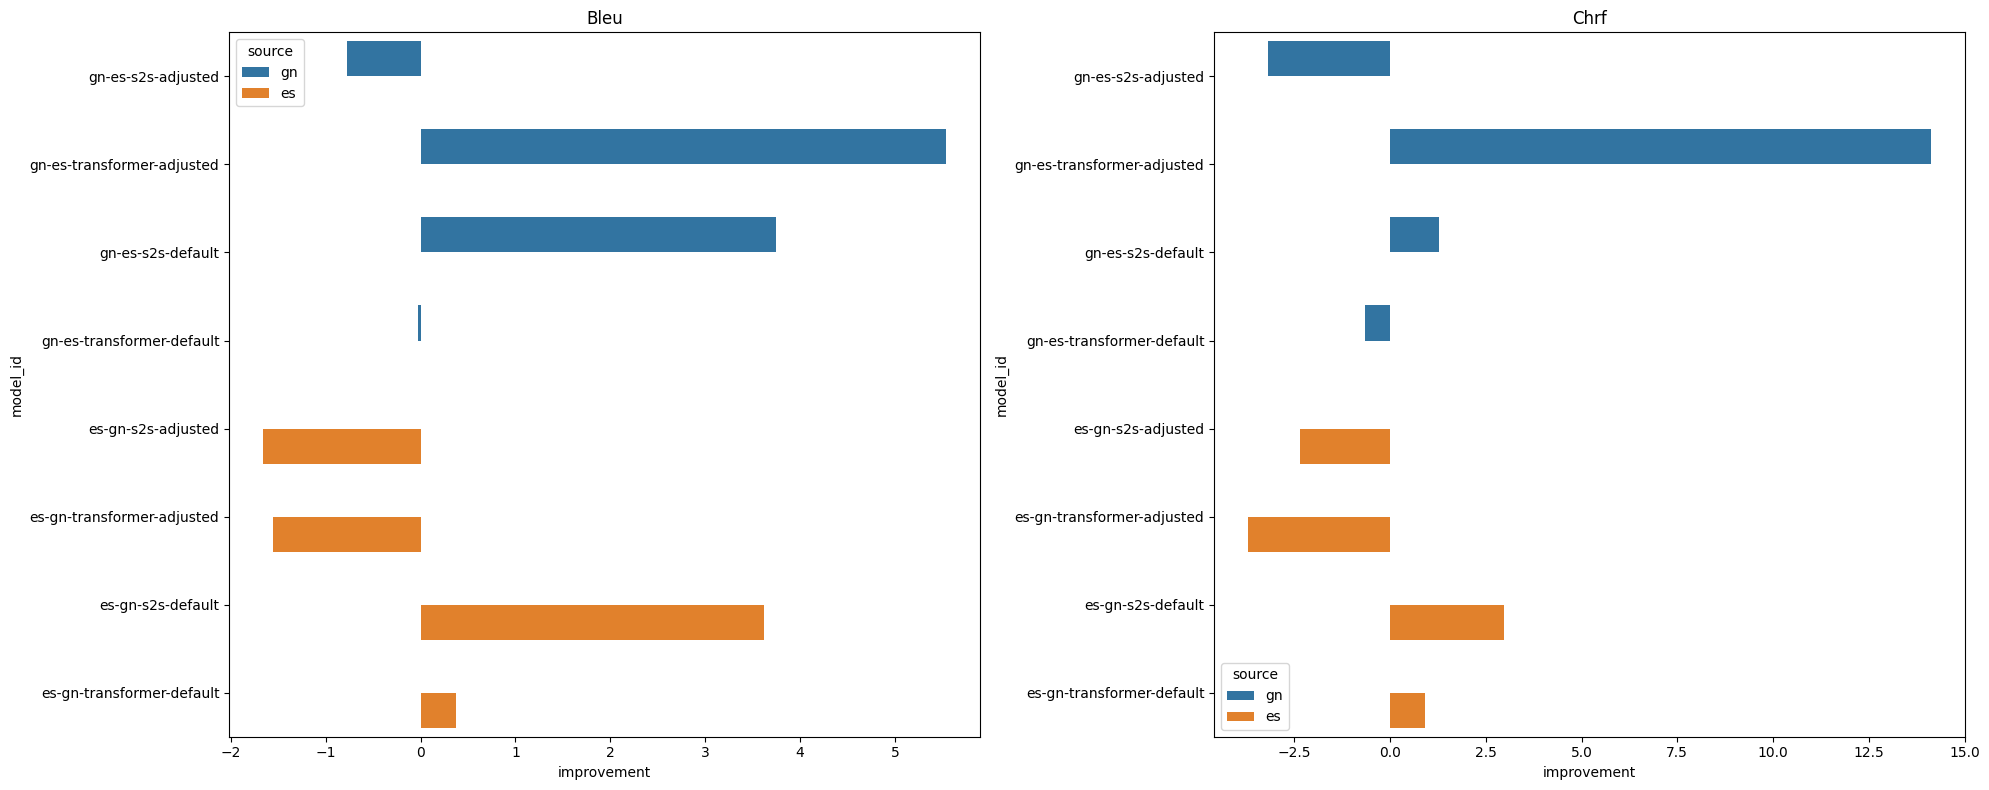

In [41]:
fig, ax = plt.subplots(figsize=(20, 8), ncols=2)
sns.barplot(y='model_id', x='improvement', hue='source', data=pair_df[pair_df['metric']=='sacrebleu_corpus_bleu-libro_gn'], ax=ax[0]);
sns.barplot(y='model_id', x='improvement', hue='source', data=pair_df[pair_df['metric']=='sacrebleu_corpus_chrf-libro_gn'], ax=ax[1]);

ax[0].set_title('Bleu')
ax[1].set_title('Chrf')
plt.tight_layout()

##### **2.1.2.6. libro_td**

In [42]:
current_df = extract_metric_from_subset(light_weight_df, 'libro_td', ['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'])
current_df

source target architecture hyperparameter_tuning_option pretraining_corpus  \
21     gn     es          s2s                     adjusted             ancora   
28     gn     es          s2s                     adjusted     not_pretrained   
22     gn     es          s2s                     adjusted              bible   
23     gn     es          s2s                     adjusted             merged   
0      gn     es  transformer                     adjusted            grammar   
20     gn     es          s2s                     adjusted            grammar   
7      gn     es  transformer                      default             merged   
1      gn     es  transformer                     adjusted             ancora   
25     gn     es          s2s                      default             ancora   
6      gn     es  transformer                      default              bible   
27     gn     es          s2s                      default             merged   
2      gn     es  transformer                     adjusted              bible   
4      gn     es  transformer                      default            grammar   
3      gn     es  transformer                     adjusted             merged   
5      gn     es  transformer                      default             ancora   
0      gn     es       google                      default                NaN   
26     gn     es          s2s                      default              bible   
9      gn     es  transformer                      default     not_pretrained   
24     gn     es          s2s                      default            grammar   
29     gn     es          s2s                      default     not_pretrained   
8      gn     es  transformer                     adjusted     not_pretrained   
33     es     gn          s2s                     adjusted             merged   
18     es     gn  transformer                     adjusted     not_pretrained   
30     es     gn          s2s                     adjusted            grammar   
31     es     gn          s2s                     adjusted             ancora   
37     es     gn          s2s                      default             merged   
13     es     gn  transformer                     adjusted             merged   
32     es     gn          s2s                     adjusted              bible   
38     es     gn          s2s                     adjusted     not_pretrained   
16     es     gn  transformer                      default              bible   
34     es     gn          s2s                      default            grammar   
17     es     gn  transformer                      default             merged   
15     es     gn  transformer                      default             ancora   
10     es     gn  transformer                     adjusted            grammar   
19     es     gn  transformer                      default     not_pretrained   
11     es     gn  transformer                     adjusted             ancora   
35     es     gn          s2s                      default             ancora   
14     es     gn  transformer                      default            grammar   
12     es     gn  transformer                     adjusted              bible   
1      es     gn       google                      default                NaN   
39     es     gn          s2s                      default     not_pretrained   
36     es     gn          s2s                      default              bible   

     pretraining_option  sacrebleu_corpus_bleu  \
21          pretraining               26.83030   
28  without_pretraining               25.53190   
22          pretraining               25.97270   
23          pretraining               26.20430   
0           pretraining               14.78390   
20          pretraining               25.63350   
7           pretraining                7.80215   
1           pretraining               17.24340   
25          pretraining               15.24880   
6           pretrai

In [43]:
pair_df = match_pretraining_enhancement(pretraining_corpus='grammar', subset='libro_td')
pair_df

source target architecture hyperparameter_tuning_option  \
0      gn     es          s2s                     adjusted   
1      gn     es          s2s                     adjusted   
2      gn     es  transformer                     adjusted   
3      gn     es  transformer                     adjusted   
4      gn     es          s2s                      default   
5      gn     es          s2s                      default   
6      gn     es  transformer                      default   
7      gn     es  transformer                      default   
8      es     gn          s2s                     adjusted   
9      es     gn          s2s                     adjusted   
10     es     gn  transformer                     adjusted   
11     es     gn  transformer                     adjusted   
12     es     gn          s2s                      default   
13     es     gn          s2s                      default   
14     es     gn  transformer                      default   
15     es     gn  transformer                      default   

                            metric  improvement                    model_id  
0   sacrebleu_corpus_bleu-libro_td    -3.764071          gn-es-s2s-adjusted  
1   sacrebleu_corpus_chrf-libro_td    -1.750997          gn-es-s2s-adjusted  
2   sacrebleu_corpus_bleu-libro_td    12.780990  gn-es-transformer-adjusted  
3   sacrebleu_corpus_chrf-libro_td    23.417763  gn-es-transformer-adjusted  
4   sacrebleu_corpus_bleu-libro_td     0.548601           gn-es-s2s-default  
5   sacrebleu_corpus_chrf-libro_td     0.983322           gn-es-s2s-default  
6   sacrebleu_corpus_bleu-libro_td     1.043552   gn-es-transformer-default  
7   sacrebleu_corpus_chrf-libro_td     0.979662   gn-es-transformer-default  
8   sacrebleu_corpus_bleu-libro_td     1.669106          es-gn-s2s-adjusted  
9   sacrebleu_corpus_chrf-libro_td     1.614308          es-gn-s2s-adjusted  
10  sacrebleu_corpus_bleu-libro_td    -3.095724  es-gn-transformer-adjusted  
11  sacrebleu_corpus_chrf-libro_td    -0.838313  es-gn-transformer-adjusted  
12  sacrebleu_corpus_bleu-libro_td     4.042426           es-gn-s2s-default  
13  sacrebleu_corpus_chrf-libro_td     9.260539           es-gn-s2s-default  
14  sacrebleu_corpus_bleu-libro_td    -0.889915   es-gn-transformer-default  
15  sacrebleu_corpus_chrf-libro_td     2.876087   es-gn-transformer-default

In [44]:
pair_df.describe()

improvement
count    16.000000
mean      3.054833
std       6.879074
min      -3.764071
25%      -0.851214
50%       1.013437
75%       3.167672
max      23.417763

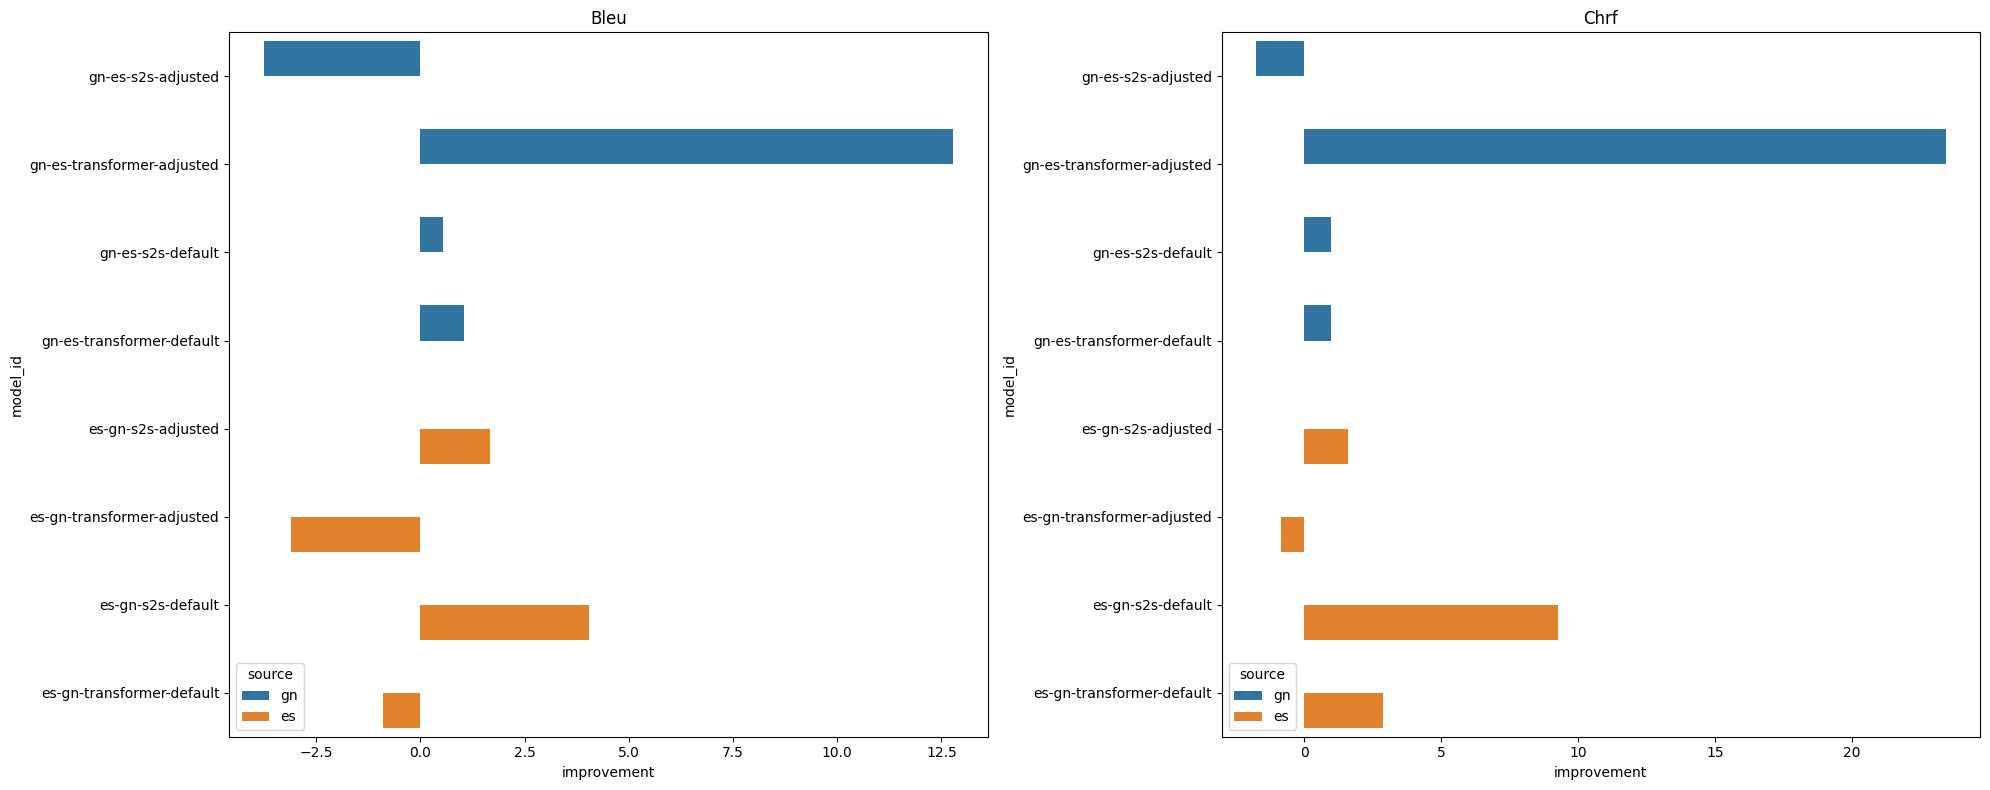

In [45]:
fig, ax = plt.subplots(figsize=(20, 8), ncols=2)
sns.barplot(y='model_id', x='improvement', hue='source', data=pair_df[pair_df['metric']=='sacrebleu_corpus_bleu-libro_td'], ax=ax[0]);
sns.barplot(y='model_id', x='improvement', hue='source', data=pair_df[pair_df['metric']=='sacrebleu_corpus_chrf-libro_td'], ax=ax[1]);

ax[0].set_title('Bleu')
ax[1].set_title('Chrf')
plt.tight_layout()

##### **2.1.2.7. seminario**

In [46]:
current_df = extract_metric_from_subset(light_weight_df, 'seminario', ['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'])
current_df

source target architecture hyperparameter_tuning_option pretraining_corpus  \
0      gn     es       google                      default                NaN   
21     gn     es          s2s                     adjusted             ancora   
23     gn     es          s2s                     adjusted             merged   
28     gn     es          s2s                     adjusted     not_pretrained   
22     gn     es          s2s                     adjusted              bible   
20     gn     es          s2s                     adjusted            grammar   
3      gn     es  transformer                     adjusted             merged   
1      gn     es  transformer                     adjusted             ancora   
0      gn     es  transformer                     adjusted            grammar   
2      gn     es  transformer                     adjusted              bible   
25     gn     es          s2s                      default             ancora   
27     gn     es          s2s                      default             merged   
26     gn     es          s2s                      default              bible   
24     gn     es          s2s                      default            grammar   
7      gn     es  transformer                      default             merged   
4      gn     es  transformer                      default            grammar   
5      gn     es  transformer                      default             ancora   
9      gn     es  transformer                      default     not_pretrained   
8      gn     es  transformer                     adjusted     not_pretrained   
29     gn     es          s2s                      default     not_pretrained   
6      gn     es  transformer                      default              bible   
1      es     gn       google                      default                NaN   
31     es     gn          s2s                     adjusted             ancora   
33     es     gn          s2s                     adjusted             merged   
32     es     gn          s2s                     adjusted              bible   
38     es     gn          s2s                     adjusted     not_pretrained   
30     es     gn          s2s                     adjusted            grammar   
13     es     gn  transformer                     adjusted             merged   
11     es     gn  transformer                     adjusted             ancora   
10     es     gn  transformer                     adjusted            grammar   
18     es     gn  transformer                     adjusted     not_pretrained   
12     es     gn  transformer                     adjusted              bible   
37     es     gn          s2s                      default             merged   
35     es     gn          s2s                      default             ancora   
34     es     gn          s2s                      default            grammar   
17     es     gn  transformer                      default             merged   
14     es     gn  transformer                      default            grammar   
16     es     gn  transformer                      default              bible   
19     es     gn  transformer                      default     not_pretrained   
15     es     gn  transformer                      default             ancora   
39     es     gn          s2s                      default     not_pretrained   
36     es     gn          s2s                      default              bible   

     pretraining_option  sacrebleu_corpus_bleu  \
0   without_pretraining               26.96010   
21          pretraining               26.83030   
23          pretraining               26.20430   
28  without_pretraining               25.53190   
22          pretraining               25.97270   
20          pretraining               25.63350   
3           pretraining               20.36690   
1           pretraining               17.24340   
0           pretraining               14.78390   
2           pretrai

##### **2.1.2.8. spl**

In [47]:
current_df = extract_metric_from_subset(light_weight_df, 'spl', ['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'])
current_df

source target architecture hyperparameter_tuning_option pretraining_corpus  \
22     gn     es          s2s                     adjusted              bible   
28     gn     es          s2s                     adjusted     not_pretrained   
20     gn     es          s2s                     adjusted            grammar   
21     gn     es          s2s                     adjusted             ancora   
23     gn     es          s2s                     adjusted             merged   
3      gn     es  transformer                     adjusted             merged   
1      gn     es  transformer                     adjusted             ancora   
0      gn     es       google                      default                NaN   
0      gn     es  transformer                     adjusted            grammar   
2      gn     es  transformer                     adjusted              bible   
25     gn     es          s2s                      default             ancora   
27     gn     es          s2s                      default             merged   
26     gn     es          s2s                      default              bible   
24     gn     es          s2s                      default            grammar   
4      gn     es  transformer                      default            grammar   
5      gn     es  transformer                      default             ancora   
7      gn     es  transformer                      default             merged   
9      gn     es  transformer                      default     not_pretrained   
6      gn     es  transformer                      default              bible   
8      gn     es  transformer                     adjusted     not_pretrained   
29     gn     es          s2s                      default     not_pretrained   
38     es     gn          s2s                     adjusted     not_pretrained   
33     es     gn          s2s                     adjusted             merged   
32     es     gn          s2s                     adjusted              bible   
31     es     gn          s2s                     adjusted             ancora   
30     es     gn          s2s                     adjusted            grammar   
18     es     gn  transformer                     adjusted     not_pretrained   
13     es     gn  transformer                     adjusted             merged   
11     es     gn  transformer                     adjusted             ancora   
10     es     gn  transformer                     adjusted            grammar   
37     es     gn          s2s                      default             merged   
12     es     gn  transformer                     adjusted              bible   
1      es     gn       google                      default                NaN   
35     es     gn          s2s                      default             ancora   
34     es     gn          s2s                      default            grammar   
15     es     gn  transformer                      default             ancora   
17     es     gn  transformer                      default             merged   
14     es     gn  transformer                      default            grammar   
16     es     gn  transformer                      default              bible   
19     es     gn  transformer                      default     not_pretrained   
39     es     gn          s2s                      default     not_pretrained   
36     es     gn          s2s                      default              bible   

     pretraining_option  sacrebleu_corpus_bleu  sacrebleu_corpus_bleu-spl  \
22          pretraining               25.97270                  33.975979   
28  without_pretraining               25.53190                  33.164748   
20          pretraining               25.63350                  32.199632   
21          pretraining               26.83030                  31.211923   
23          pretraining               26.20430                  30.588465   
3           pretraining               20.36690           

### **2.2 By Special Cases**

In [48]:
def plot_values_by_index(title, values, color=None, ax=None, source_indices:list=None, source_names:list=None):
    import random; random.seed(0)

    sns.set_style('darkgrid')
    x = list(range(len(values)))
    y = values

    if ax is None:
        plt.figure(figsize=(20, 6))
        ax = sns.lineplot(x=x, y=y, color=color)
    else:
        ax.plot(x, y, color=color)

    if source_indices is not None and source_names is not None:
        for i, source_index in enumerate(source_indices):
            ax.axvline(source_index, color='black')
            ax.text(source_index - 150,
                    -20,
                    source_names[i],
                    verticalalignment='top',
                    rotation=90,
                    fontdict={'size': 12})
            
    # Plot moving average
    moving_average = []
    confidence_interval = []
    moving_average_window = 200

    for i in range(len(values)):
        source_base_idx = max([0] + [idx for idx in source_indices if idx <= i]) # Consider being outside of source index
        start_idx = max(0, i-moving_average_window, source_base_idx)
        end_idx = i
        divisor = end_idx - start_idx + 1
        current_values = values[start_idx:i+1]
        current_mean = sum(current_values) / divisor
        current_std = statistics.stdev(current_values) if len (current_values) > 1 else 0

        moving_average.append(current_mean)
        confidence_interval.append(current_std)

    
    ax.plot(x, moving_average, color='black', alpha=0.8)
    ax.fill_between(x, [mean - std for mean, std in zip(moving_average, confidence_interval)], 
                        [mean + std for mean, std in zip(moving_average, confidence_interval)], 
                        alpha=0.2, color='black', zorder=2)
    
    # Remove xtick = 4000
    ax.set_xticks([0, 1000, 2000, 3000, 5000])

    ax.set_title(title)
    ax.set_xlabel('Index')
    ax.set_ylabel('Value')
    plt.tight_layout()

    if ax is None:
        plt.show()

In [49]:
def plot_individual_metrics(df, source_indices:list=None, source_names:list=None):
    _, ax = plt.subplots(figsize=(20, len(df)*4), nrows=len(df), ncols=2)

    for i, (_, row) in enumerate(df.iterrows()):
        test_filelines = test_gn_filelines if row['target'] == 'gn' else test_es_filelines
        filelines = row['filelines']
        metric_df = create_bleu_scores_df(test_filelines, filelines, bleu_score_types=['sacrebleu_sentence_chrf', 'sacrebleu_sentence_bleu'])
        sacrebleu_scores = metric_df[metric_df['metric'] == 'sacrebleu_sentence_bleu']['score']
        chrf_scores = metric_df[metric_df['metric'] == 'sacrebleu_sentence_chrf']['score']

        best_df_row = row
        plot_values_by_index(f'BLEU: {best_df_row["sacrebleu_corpus_bleu"]} | {best_df_row["architecture"]} {best_df_row["source"]}->{best_df_row["target"]} {best_df_row["pretraining_option"]} {best_df_row["pretraining_corpus"]} {best_df_row["hyperparameter_tuning_option"]}', 
                            sacrebleu_scores, 
                            color='brown',
                            ax=ax[i, 0],
                            source_indices=source_indices,
                            source_names=source_names)
        plot_values_by_index(f'chrF: {best_df_row["sacrebleu_corpus_chrf"]} | {best_df_row["architecture"]} {best_df_row["source"]}->{best_df_row["target"]} {best_df_row["pretraining_option"]} {best_df_row["pretraining_corpus"]} {best_df_row["hyperparameter_tuning_option"]}', 
                            chrf_scores, 
                            ax=ax[i, 1],
                            source_indices=source_indices,
                            source_names=source_names)

**Grammar enhancement**

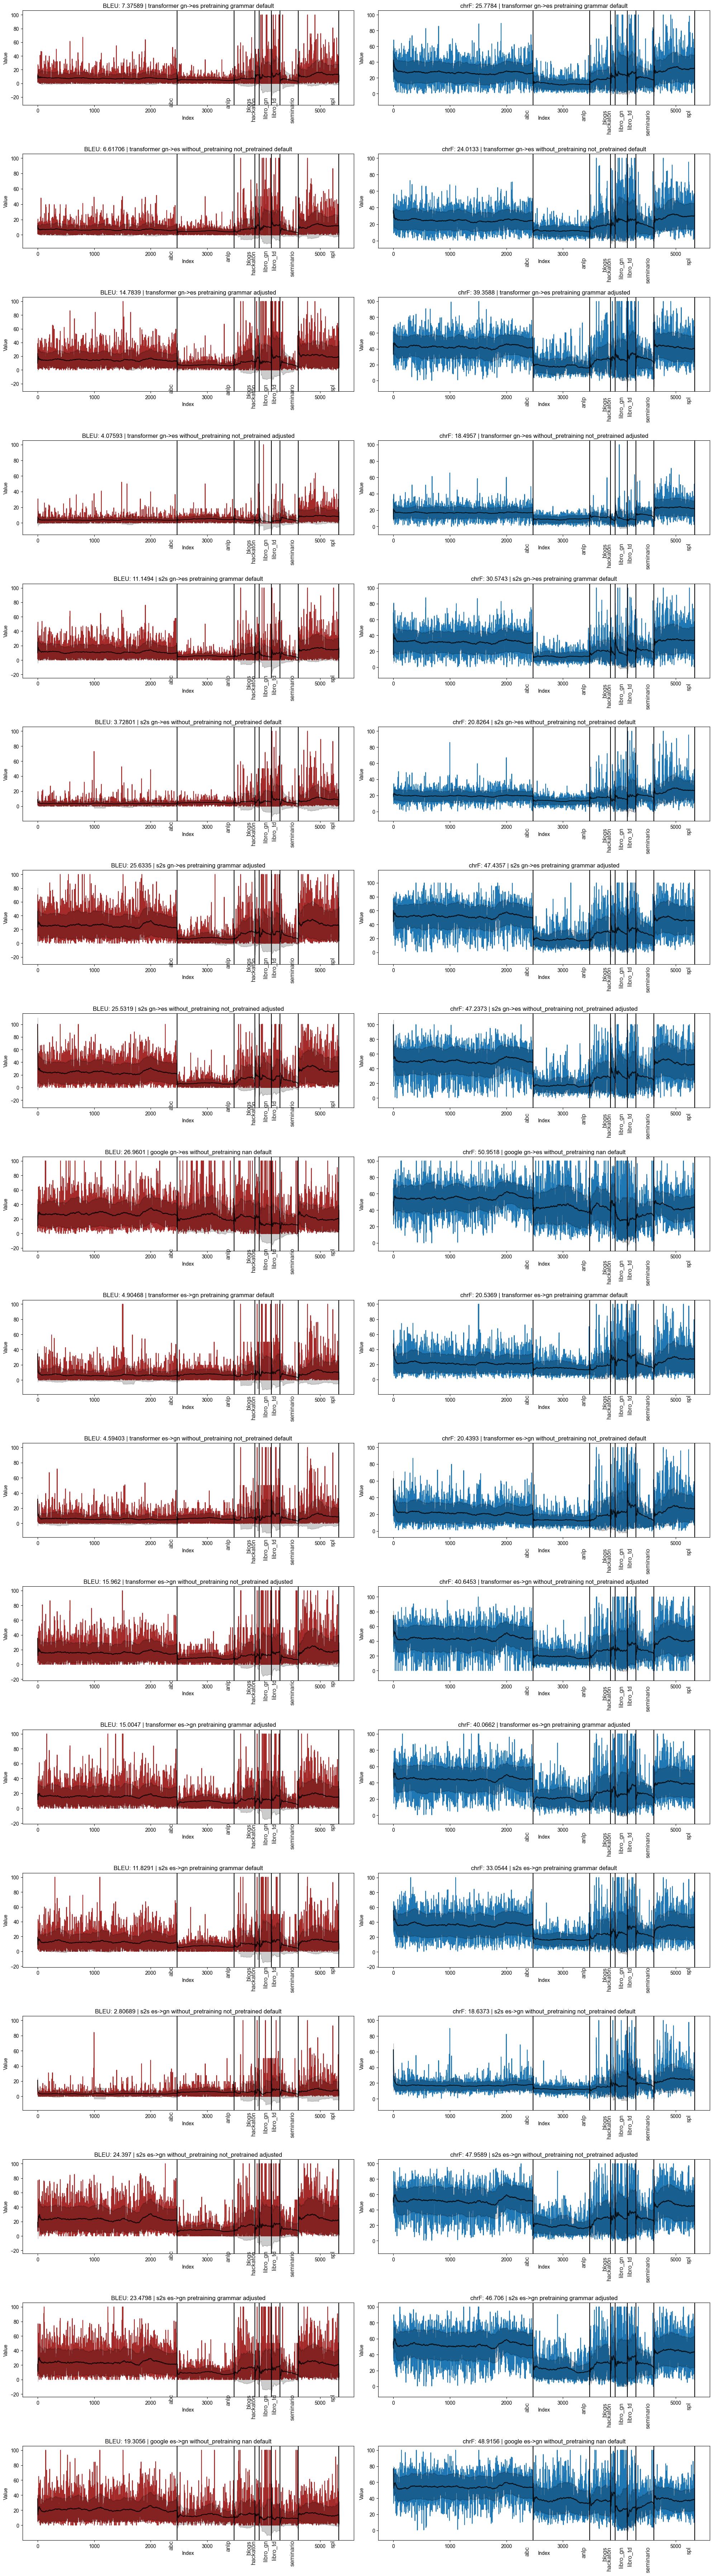

In [50]:
grammar_comparison_df = df[(df['pretraining_corpus']=='grammar') | (df['pretraining_option']=='without_pretraining')]
grammar_comparison_df = grammar_comparison_df.sort_values(by=['source', 
                                                              'architecture', 
                                                              'hyperparameter_tuning_option', 
                                                              'sacrebleu_corpus_bleu'], 
                                                          ascending=False)
plot_individual_metrics(grammar_comparison_df, 
                        source_indices=last_source_indices, 
                        source_names=source_names)

**Google**

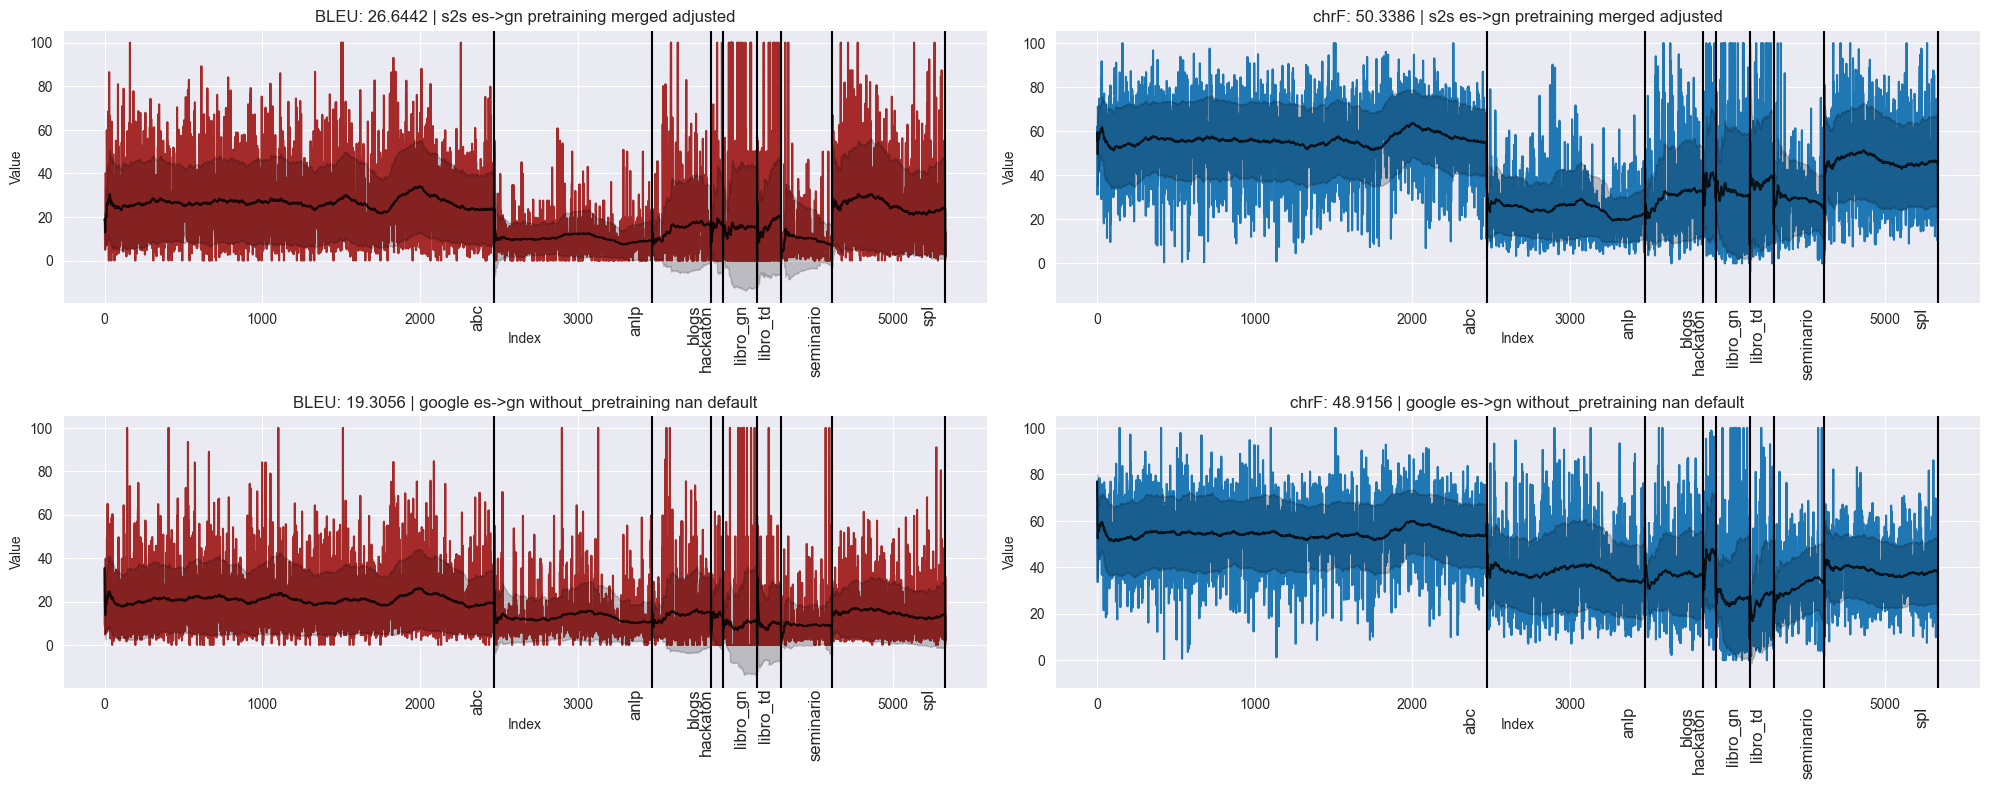

In [51]:
best_dfs = df[((df['sacrebleu_corpus_chrf'] > 50) | (df['architecture']=='google')) & (df['source']=='es')]
plot_individual_metrics(best_dfs, 
                        source_indices=last_source_indices, 
                        source_names=source_names)